# M=1 Transformer

In [2]:
import os
from dotenv import load_dotenv

load_dotenv();

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

from devinterp.mechinterp.hooks import hook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# import sys
# del sys.modules['icl.figures.colors']
# del sys.modules['icl.figures.notation']

from icl.analysis.utils import get_unique_run
from icl.constants import ANALYSIS, FIGURES, SWEEPS
from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN

DEVICE = 'mps'
MODEL_ID = "L2H4M1"
LLC_RUN_ID = "5e0cq1db"

sns.set_style('whitegrid')

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [4]:
NUM_TASKS = 1
NUM_LAYERS = 2
MAX_LR = 0.01

# shorthands
BATCH_SIZE = 8192
K = 8
D = 4

run = get_unique_run(
    str(SWEEPS / "training-runs/small-L-2.yaml"), 
    task_config={"num_tasks": NUM_TASKS, "num_layers": NUM_LAYERS},
    optimizer_config={"lr": MAX_LR}
)

/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/icl/analysis/baselines.py:165: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  ws_hat = torch.linalg.solve(LHS, RHS)   # BKDD^-1 @ BKD1 -> B K D 1


In [5]:
from copy import deepcopy 
# Let's generate these same plots and also look at their evolution. 
models = []
optimizer_state_dicts = []

steps = run.checkpointer.file_ids

for checkpoint in run.checkpointer:
    m = deepcopy(run.model)
    m.load_state_dict(checkpoint["model"])
    models.append(m)
    optimizer_state_dicts.append(checkpoint["optimizer"])


In [6]:
# Let's look at how the curvature of the llc changes over time. 

import wandb

api = wandb.Api()
llc_run = api.run(f"devinterp/icl/{LLC_RUN_ID}")
history_df = llc_run.history()

llc_steps = history_df["_step"]
llcs = history_df["llc/mean"]
llcs_std = history_df["llc/std"]


In [7]:
from icl.figures.derivatives import d_dt, d_dlogt, dlog_dlogt

weight_norms = [(sum(torch.norm(p) ** 2 for p in model.parameters()) ** 0.5).item() for model in models]

d_llc_dt = d_dt(steps, llcs)
d_llc_dlogt = d_dlogt(steps, llcs)

d_weight_norm_dt = d_dt(run.checkpointer.file_ids, weight_norms)
d_weight_norm_dlogt = d_dlogt(run.checkpointer.file_ids, weight_norms)

In [8]:
from icl.analysis.evals import ICLEvaluator

FORCE_REEVAL = True

evaluator = ICLEvaluator(
    pretrain_dist=run.pretrain_dist,
    true_dist=run.true_dist,
    max_examples=run.config.task_config.max_examples,
    eval_batch_size=BATCH_SIZE,
    seed=run.config.task_config.true_seed,   
)

if os.path.exists(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv") and not FORCE_REEVAL:
    evals_over_time_df = pd.read_csv(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv")
    evals_over_time = evals_over_time_df.to_dict("records")
else:
    evals_over_time = [evaluator(model) for model in models]
    evals_over_time_df = pd.DataFrame(evals_over_time)
    evals_over_time_df.to_csv(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv")

evals_over_time_df

KeyboardInterrupt: 

In [ ]:
evals_over_time_df.columns

In [12]:
import colorsys
from matplotlib.colors import LinearSegmentedColormap


TRANSITIONS = [
    (30, 600, 'A1'),
    (600, 12500, 'A2'),
    (12500, 60000, 'B1'),
    (60000, 110000, 'B2'),
    (110000, 180000, 'B3'),
    (180000, 280000, "B4"),
    (280000, 320000, "B5"),
    (320000, 500000, "B6")
]


# def gen_transition_colors(types):
#     """Generates a palette for transition colors. Orange-flavored for Type A. Blue-flavored for Type B."""
#     num_type_a = sum([t == "A" for t in types])
#     num_type_b = sum([t == "B" for t in types])
#     num_other = sum([t == "Other" for t in types])

#     type_a_palette = sns.color_palette("Oranges_r", num_type_a)
#     type_b_palette = sns.color_palette("Blues_r", num_type_b)
#     other_palette = sns.color_palette("Greys_r", num_other)

#     palette = []

#     for t in types:
#         if t == "A":
#             palette.append(type_a_palette.pop())
#         elif t == "B":
#             palette.append(type_b_palette.pop())
#         else:
#             palette.append(other_palette.pop())

#     return palette


def increase_saturation(rgb, saturation_factor):
    # Convert RGB to HSV
    hsv = colorsys.rgb_to_hsv(*rgb)
    
    # Increase saturation by the given factor, making sure it stays in [0, 1]
    new_s = min(max(hsv[1] * saturation_factor, 0), 1)
    
    # Convert back to RGB
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, hsv[2])
    return new_rgb


def increase_contrast(rgb, contrast_factor):
    # Midpoint
    midpoint = 128.0 / 255
    
    # Increase contrast
    new_rgb = [(0.5 + contrast_factor * (component - 0.5)) for component in rgb]
    
    # Clip to the range [0, 1]
    new_rgb = [min(max(component, 0), 1) for component in new_rgb]
    return new_rgb



transition_types = [get_transition_type(t) for t in TRANSITIONS]
transition_colors = gen_transition_colors(transition_types)

transition_colors = [increase_saturation(rgb, 2) for rgb in transition_colors]
transition_colors = [increase_contrast(rgb, 2) for rgb in transition_colors]

transitions_cmap = LinearSegmentedColormap.from_list("transitions", transition_colors)

In [ ]:
metrics_to_plot = [
    (r"L_{\mathcal{T}}(t)", evals_over_time_df["pretrain/mse_subsequence"], {"logy": True}, ),
    # (r"L_\mathcal{G}(t)", evals_over_time_df["true/mse"], {"logy": False}),
    (r"\hat \lambda(t)", llcs, {}),
    (r"|\theta(t)|", weight_norms, {"derivative": "dlog_dlogt", "logy": True}),
] 

fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(18, 6))

for i, (metric_name, metric_values, kwargs) in enumerate(metrics_to_plot):
    axes[0, i].plot(run.checkpointer.file_ids, metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"${metric_name}$")
    axes[0, i].set_xlabel('Step, $t$')
    axes[0, i].set_ylabel(metric_name)

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope = d_dlogt(run.checkpointer.file_ids, metric_values)
        slope_name = str_d_dlogt(metric_name)
    elif slope_type == "d_dt":
        slope = d_dt(run.checkpointer.file_ids, metric_values)
        slope_name = str_d_dt(metric_name)
    elif slope_type == "dlog_dlogt":
        slope = dlog_dlogt(run.checkpointer.file_ids, metric_values)
        slope_name = str_dlog_dlogt(metric_name)
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    axes[1, i].plot(run.checkpointer.file_ids, slope, label=metric_name + " Slope", marker='.')
    axes[1, i].set_title(slope_name)
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(slope_name)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(30, 500_000)

# axes[0, 1].set_ylim(0, 100)
# axes[1, 1].set_ylim(0, 200)
# axes[1,1].set_ylim(-2, 2)

patch_list = plot_transitions(axes, TRANSITIONS)

milestone_labels = [label for _, _, label in TRANSITIONS]
fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))

fig.set_facecolor("white")
fig.tight_layout()

# Behavioral Indicators

## Loss, Prediction Norm, OOD Loss

In [10]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from devinfra.utils.seed import set_seed
from icl.tasks import apply_transformations
from devinfra.utils.iterables import flatten_dict

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.pretrain_seed)


# sample a batch of random tasks
ws = pretrain_dist_noiseless.task_distribution.sample_tasks(BATCH_SIZE) # -> B D

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(BATCH_SIZE, K, D,),
    device=DEVICE
)

OOD_MULTIPLIER = 5

ood_xs = 100 * xs
ys = apply_transformations(ws, xs, 0.125, DEVICE)
ood_ys = apply_transformations(ws, ood_xs, 0.125, DEVICE)

def eval_loss(yhats, ys):
    losses = ((yhats - ys) ** 2).mean(dim=0)[:, 0]
    return [loss.item() for loss in losses] + [losses.mean().item()]

losses_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    losses = eval_loss(model(xs, ys), ys)
    ood_losses = eval_loss(model(ood_xs, ood_ys), ood_ys)
    losses_0s = eval_loss(model(xs, ys), torch.zeros_like(ys))

    for i in range(9):
        losses_over_time.append({
            "step": step,
            "loss": losses[i],
            "ood_loss": ood_losses[i],
            "loss_0": losses_0s[i],
            # "token": f"$\hat y_{i+1}$" if i < 8 else "$\overline{\hat y}$"
            "token": i + 1 if i < 8 else "$\overline{\hat y}$"
        })

losses_over_time = pd.DataFrame(losses_over_time)
losses_over_time

,step,loss,ood_loss,loss_0,token
0,0,1.951731,8632.254883,0.631329,1
1,0,1.850801,8996.295898,0.463660,2
2,0,1.986610,9083.861328,0.594626,3
3,0,1.844336,8825.272461,0.426411,4
4,0,1.909071,9165.722656,0.440620,5
...,...,...,...,...,...
859,499999,0.015180,7078.620117,0.910614,5
860,499999,0.016119,7023.177734,0.902941,6
861,499999,0.015495,7051.766602,0.910010,7
862,499999,0.015827,6800.815430,0.877022,8


## In-context learning score

In [ ]:
from matplotlib import colors as mcolors

LINE_PALETTE="viridis"
ALPHA=1

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=losses_over_time, x="step", y="loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

plot_transitions(ax, TRANSITIONS, limit=True) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

# custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


In [ ]:
from matplotlib import colors as mcolors

LINE_PALETTE="viridis"
ALPHA=1

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

icl_score = losses_over_time.loc[losses_over_time.token == 8, "loss"].values - losses_over_time.loc[losses_over_time.token == 1, "loss"].values
sns.lineplot(x=steps, y=icl_score, alpha=ALPHA, ax=ax)
    
# ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

plot_transitions(ax, TRANSITIONS, limit=True) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

# custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


## Behavioral Essential Dynamics

In [15]:
# Do the PCAs again. 
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor
from matplotlib import colors as mcolors


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        model.to(DEVICE)
        xs.to(model.device)
        ys.to(model.device)
        hooked_model = hook(model, *paths)
        outputs, activations = hooked_model.run_with_cache(xs, ys)
        activations[""] = outputs
        return {k: convert_tensor(v, return_type) for k, v in activations.items() if (k in paths or k == "") and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, normalize=False):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            if normalize:
                activation = activation / np.linalg.norm(activation)

            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }


def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3, normalize=False) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths, normalize=normalize).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results


tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap
colors = tab10.colors[:len(TRANSITIONS)]  # Get the first 6 colors 
# Add an extra gray to this np array for extra colors
colors = np.vstack((colors, np.array([0.8, 0.8, 0.8, 1.0])))

# Create a new colormap from the extracted colors
custom_cmap = mcolors.ListedColormap(colors)

# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)
train_xs_1, train_ys_1 = pretrain_dist_noiseless.get_batch(8, 1024)

traces = get_pca_activations_trace(
    models,
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    # "token_sequence_transformer.blocks.1",
    # "token_sequence_transformer.token_embedding",
    num_components=3,
    normalize=False
) 

# traces_small = get_pca_activations_trace(
#     models,
#     train_xs_1[:1024], 
#     train_ys_1[:1024], 
#     "",
#     "token_sequence_transformer.blocks.1",
#     # "token_sequence_transformer.token_embedding",
#     num_components=3,
#     normalize=False
# ) 

pca_outputs, logits_outputs = traces[""]
pca_logits, logits_reduced = traces["token_sequence_transformer"]
# pca_internal, activations_reduced = traces_small["token_sequence_transformer.blocks.1"]

traces_normalized = get_pca_activations_trace(
    models,
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    # "token_sequence_transformer.blocks.1",
    # "token_sequence_transformer.token_embedding",
    num_components=3,
    normalize=True
) 

# traces_small_normalized = get_pca_activations_trace(
#     models,
#     train_xs_1[:1024], 
#     train_ys_1[:1024], 
#     # "token_sequence_transformer",
#     "token_sequence_transformer.blocks.1",
#     # "token_sequence_transformer.token_embedding",
#     num_components=3,
#     normalize=True
# ) 

pca_outputs_normalized, activations_outputs_normalized = traces_normalized[""]
pca_internal_normalized, activations_reduced_normalized = traces_normalized["token_sequence_transformer"]
# pca_internal, activations_reduced = traces_small["token_sequence_transformer.blocks.1"]

<ipython-input-15-8da1dbd3ca77>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap


In [17]:
import matplotlib.pyplot as plt
import os
from typing import Optional

def get_transition_indices(steps, transitions):
    transition_indices = []
    for step in steps:
        # Find the index of the transition that the current step falls into
        index = next((i for i, transition in enumerate(transitions) if transition[0] <= step < transition[1]), None)
        transition_indices.append(index if index is not None else -1)

    return transition_indices

def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]

def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('PC')
    ax.set_ylabel('Explained Variance')

    ax.set_xticks(range(len(pca.explained_variance_ratio_)), range(1, len(pca.explained_variance_ratio_) + 1))


def plot_multiple_slices(steps, samples, pca, highlighted_steps, transition_idxs, ave: Optional[str] = None, connect_dots=False, cmap=custom_cmap, alpha=1, save=False, line_color="auto"):
    num_pca_components = samples.shape[-1]
    
    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=(20, 4))
    # fig.suptitle(title)

    # Ensure ax is iterable by converting to a list if there's only one subplot
    if num_pca_components == 2:
        axes = [axes]


    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):

            if connect_dots:
                axes[I].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            sc = axes[I].scatter(samples[:, i], samples[:, j], c=transition_idxs, cmap=cmap, s=50, alpha=alpha)
            axes[I].set_xlabel(f'PC {i}')
            axes[I].set_ylabel(f'PC {j}')
            axes[I].set_title(f'PC {i} vs PC {j}')

            # Label some points
            total_samples = len(samples)
            for step in highlighted_steps:
                k = steps.index(step)  # Find the index of the highlighted step
                axes[I].text(samples[k, i], samples[k, j], str(step), fontsize=8, ha='right', va='bottom', alpha=0.5)

            I += 1

    plot_explained_variance(pca, ax=axes[-1])
    # for I in range( num_pca_combos):
    #     axes[I].axis('off')
            
    # Colorbar for the last plot
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as necessary
        # plt.colorbar(sc, cax=cbar_ax, label='Milestones')

    # Plot the legend on the first subplot on the left
    legend_ax = axes[0]
    scatter_proxy = [plt.Line2D([0], [0], linestyle='none', marker='o', alpha=alpha, color=cmap(i / len(TRANSITIONS))) for i in range(len(transition_idxs))]
    legend_labels = [label for _, _, label in TRANSITIONS]
    legend_ax.legend(scatter_proxy, legend_labels, loc='center', ncol=1, frameon=False, bbox_to_anchor=(-0.5, 0.5), title='Developmental Stages')
    # legend_ax.set_title()

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right side to make room for the colorbar

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


    fig.set_facecolor('white')
    
# Usage of the function
# Call the function with your data and the list of highlighted steps
# plot_multiple_slices(steps, samples, pca, highlighted_steps=[100, 1000, 10000], title="Your Title", num_points_to_label=10, save="path/to/save.png", connect_dots=True)


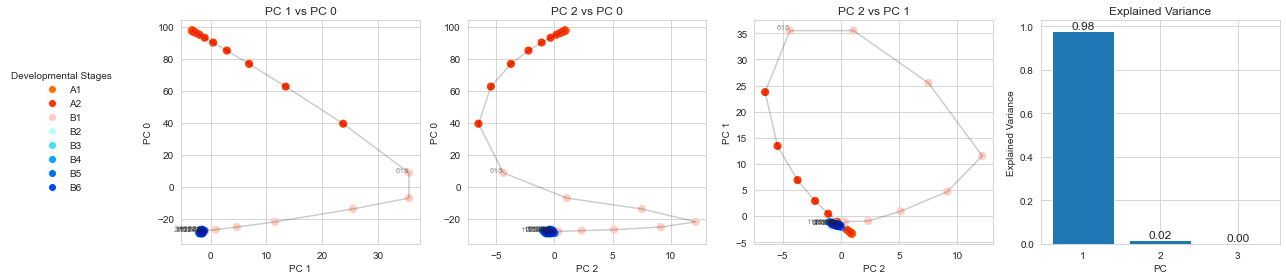

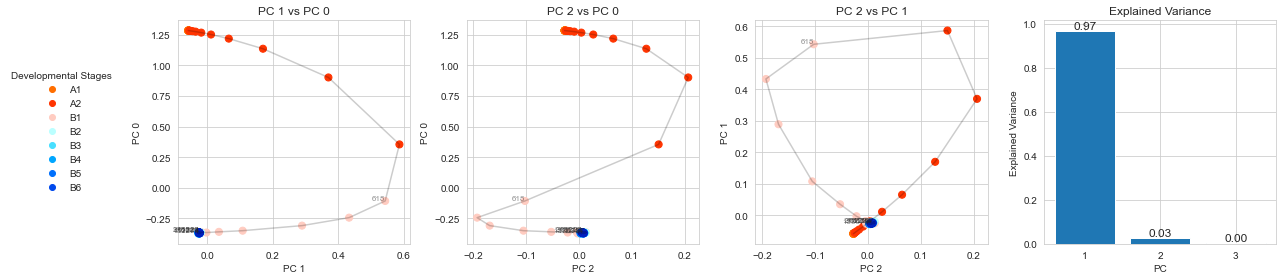

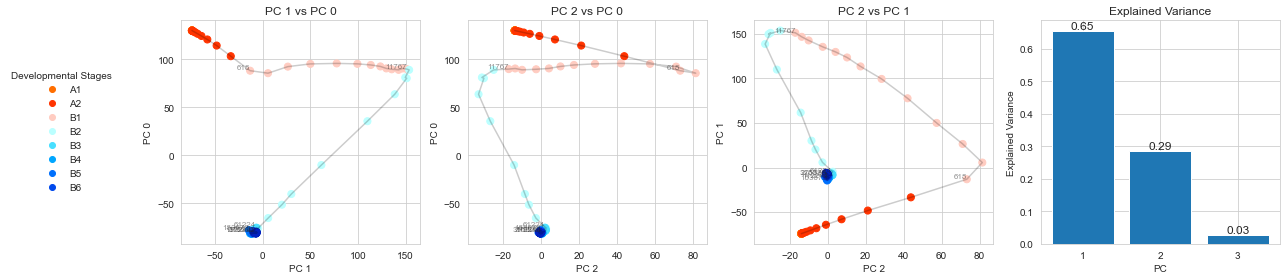

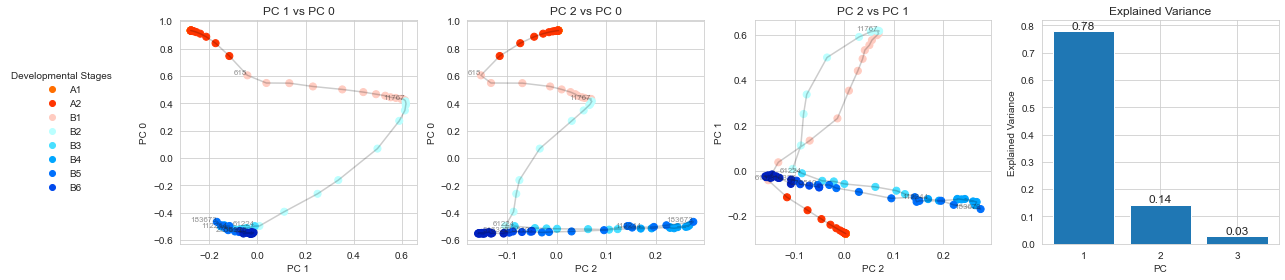

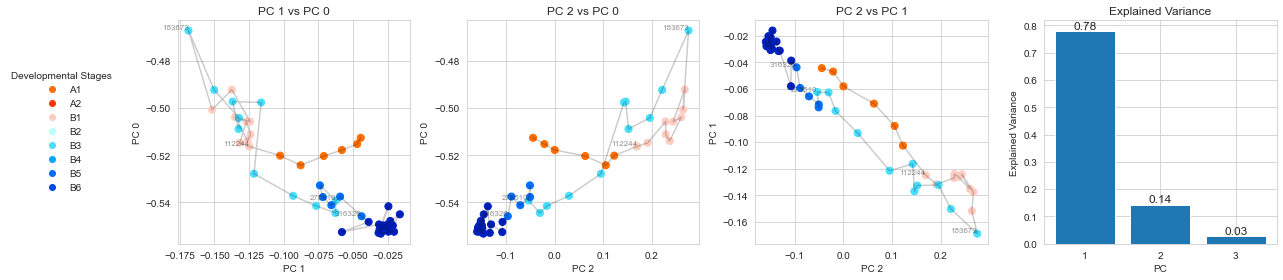

In [20]:
transitions_of_steps = get_transition_indices(steps, TRANSITIONS)
highlight_steps = list(map(get_nearest_step, [t[0] for t in TRANSITIONS][1:]))

plot_multiple_slices(
    steps, 
    logits_outputs, 
    pca_outputs, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
    cmap=transitions_cmap
)
plt.show()


plot_multiple_slices(
    steps, 
    activations_outputs_normalized, 
    pca_outputs_normalized, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
    cmap=transitions_cmap
)
plt.show()


plot_multiple_slices(
    steps, 
    logits_reduced, 
    pca_logits, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
    cmap=transitions_cmap
)
plt.show()


plot_multiple_slices(
    steps, 
    activations_reduced_normalized, 
    pca_internal_normalized, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
    cmap=transitions_cmap
)
plt.show()

LAST_CHECKPOINT_IDXS = -50
last_steps = steps[LAST_CHECKPOINT_IDXS:]
last_highlight_steps = [step for step in highlight_steps if step in last_steps]

plot_multiple_slices(
    last_steps, 
    activations_reduced_normalized[LAST_CHECKPOINT_IDXS:], 
    pca_internal_normalized, 
    last_highlight_steps,
    transitions_of_steps[LAST_CHECKPOINT_IDXS:],
    connect_dots=True, 
    save=None,
    cmap=transitions_cmap
)

In [ ]:
plot_multiple_slices(
    steps, 
    activations_reduced, 
    pca_internal, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None
)
plt.show()


plot_multiple_slices(
    steps, 
    activations_reduced_normalized, 
    pca_internal_normalized,
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None
)
plt.show()

# Geometric Indicators

In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

token_losses_over_time = losses_over_time.loc[losses_over_time.token != "$\overline{\hat y}$"]
mean_losses_over_time = losses_over_time.loc[losses_over_time.token == "$\overline{\hat y}$"]

sns.lineplot(data=token_losses_over_time, x="step", y=f"loss", hue="token", palette="viridis", ax=axes[0], alpha=0.5)
sns.lineplot(data=token_losses_over_time, x="step", y=f"loss_0", hue="token", palette="viridis", ax=axes[1], alpha=0.5)
sns.lineplot(data=token_losses_over_time, x="step", y=f"ood_loss", hue="token", palette="viridis", ax=axes[2], alpha=0.5)

sns.lineplot(data=mean_losses_over_time, x="step", y="loss", label="Mean", ax=axes[0], color=BRED)
sns.lineplot(data=mean_losses_over_time, x="step", y=f"loss_0", label="Mean", ax=axes[1], color=BRED)
sns.lineplot(data=mean_losses_over_time, x="step", y="ood_loss", label="Mean", ax=axes[2], color=BRED)

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("Step, $t$")
    ax.set_yscale('log')
    legend = ax.legend()
    legend.remove()
    ax.set_xlim(100, 500_000)

legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))

axes[0].set_title("MSE on in-distribution inputs over time")
axes[0].set_ylabel("MSE")

axes[1].set_title("Mean squared prediction over time")
axes[1].set_ylabel("$\|\hat y_k\|^2$")

axes[2].set_title("MSE on out-of-distribution inputs over time")
axes[2].set_ylabel("MSE")

plot_transitions(axes, TRANSITIONS)

for ax in axes:
    ax.set_xscale('log')

plt.tight_layout()
# Add color bar on the far right

fig.set_facecolor('white')

## Gradients

In [ ]:
from torch.nn import functional as F

gradient_stats = []

xs, ys = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys
xs, ys = xs.to(DEVICE), ys.to(DEVICE)


for step, model in zip(steps, models):
    model.to(DEVICE)
    model.zero_grad()

    yhats = model(xs, ys)

    loss = F.mse_loss(yhats, ys)
    loss.backward()

    for n, p in model.named_parameters():

        if p.grad is None:
            continue

        grad_sq_mean = (p.grad ** 2).mean().item()
        grad_sq_std = (p.grad ** 2).std().item()

        gradient_stats.append({
            "step": step,
            "layer": n,
            "grad/norm": grad_sq_mean ** 0.5,
            "grad_sq/mean": grad_sq_mean,
            "grad_sq/std": grad_sq_std,
            "numel": p.numel(),
            "loss": loss.item(),
        })          

        p.grad = None 

gradient_stats = pd.DataFrame(gradient_stats)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

avg_gradients = gradient_stats.groupby(['step']).mean()

grad_norm_thresholded = gradient_stats['grad/norm'].values + 0.00001

sns.lineplot(data=gradient_stats, x='step', y=grad_norm_thresholded, hue="layer", ax=ax, legend=False, alpha=0.5)
sns.lineplot(data=avg_gradients, x='step', y='grad/norm', ax=ax, legend=False, color=BRED)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Step, $t$")
ax.set_ylabel("Gradient norm, $\|w_t\|$")

_ = plot_transitions(ax, TRANSITIONS, limit=True)


In [ ]:
# Let's look at the optimizer state

names = [n for n, _ in run.model.named_parameters()]

optimizer_stats = []

for step, optimizer_state_dict in zip(steps, optimizer_state_dicts):
    for layer, g in optimizer_state_dict["state"].items():
        optimizer_stats.append({
            "step": step,
            "layer": layer,
            "layer_name": list(model.state_dict().keys())[layer],
            "exp_avg_sq_norm": g["exp_avg_sq"].norm().item() + 0.0000001
        })

optimizer_stats = pd.DataFrame(optimizer_stats)
avg_optimizer_stats = optimizer_stats.groupby('step').mean()

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=optimizer_stats, x="step", y="exp_avg_sq_norm", hue="layer", palette="viridis", ax=ax, alpha=0.5)
sns.lineplot(data=avg_optimizer_stats, x="step", y="exp_avg_sq_norm", palette="viridis", ax=ax, color=BRED)
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("Step")
ax.set_title("Gradient Norms by Layer and Step")
ax.legend().remove()

plot_transitions(ax, TRANSITIONS, limit=True)

ax.set_yscale("log")
ax.set_xscale("log")

In [ ]:
# I want to see in what order the layers reach "zero"
# 1. Figure out the earliest step for each layer where exp_avg_sq_norm < 1e-5
# 2. Order by this earliest step
# 3. List the names

threshold = 3e-7

# Find the earliest step where exp_avg_sq_norm < threshold for each layer
earliest_zero_step = optimizer_stats[optimizer_stats['exp_avg_sq_norm'] < threshold] \
    .groupby('layer_name') \
    .agg(earliest_step=('step', 'min'))

# Now, sort the layers by the earliest step where their norm goes below the threshold
sorted_layers_by_earliest_zero_step = earliest_zero_step.sort_values(by='earliest_step')
sorted_layers_by_earliest_zero_step

## Gradient essential dynamics

In [16]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del gradients_over_time
    del gradients_reduced
    del gradients_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

for layer_name in [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.unembedding.0",
    "token_sequence_transformer.blocks.0.compute.0",
    "token_sequence_transformer.blocks.0.compute.2",
    "token_sequence_transformer.blocks.1.compute.0",
    "token_sequence_transformer.blocks.1.compute.2"
]:
    layer_path = layer_name.split(".")
    last_state_dict = models[-1].state_dict()
    num_params = 0
    
    for subset in ("weight", "bias"):
        subset_full_name = layer_name + "." + subset
        if subset_full_name in last_state_dict:
            num_params += models[-1].state_dict()[subset_full_name].numel()
            
    gradients_over_time = np.zeros((len(steps), num_params))

    def get_params(model, layer_path):
        m = model
        for part in layer_path:
            m = getattr(m, part)
        
        return m

    for i, model in enumerate(models):
        # model.train()
        model.to(DEVICE)
        model.zero_grad()

        yhats = model(xs, ys)

        loss = F.mse_loss(yhats, ys)
        loss.backward()

        layer = get_params(model, layer_path)

        n = 0
        for subset in ("weight", "bias"):
            if layer and hasattr(layer, subset):
                param = getattr(layer, subset)
                if param is None:
                    continue

                numel = param.numel()
                gradients_over_time[i, n:n+numel] = param.grad.flatten().cpu().numpy()
                n += numel

    pca = PCA(n_components=50)
    gradients_reduced = pca.fit_transform(gradients_over_time)

    norms = np.linalg.norm(gradients_over_time, axis=1, keepdims=True)
    norms[norms == 0] = 1

    gradients_reduced_normalized = pca.fit_transform(gradients_over_time / norms)

    plot_multiple_slices(
        steps, 
        gradients_reduced[:, :3], 
        pca, 
        highlight_steps,
        transitions_of_steps,
        connect_dots=True, 
        save=None,
    )

    plt.show()

    tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
    gradients_tsne = tsne.fit_transform(gradients_reduced)

    plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
    plt.show()

    tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
    gradients_tsne_normalized = tsne.fit_transform(gradients_reduced_normalized)

    plt.scatter(gradients_tsne_normalized[:, 0], gradients_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
    plt.show()

NameError: name 'plot_multiple_slices' is not defined

## Gradient clustering

In [ ]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del gradients_over_time
    del gradients_reduced
    del gradients_reduced_normalized
except NameError:
    pass

PERPLEXITY = 10

def get_all_params_as_array(model):
    return np.concatenate([p.cpu().numpy().flatten() for p in model.parameters()])


def get_all_gradients_as_array(model):
    return np.concatenate([p.grad.cpu().numpy().flatten() for p in model.parameters() if p.grad is not None])

gradients_over_time = []
gradients_normalized_over_time = []

for i, model in enumerate(models):
    # model.train()
    model.to(DEVICE)
    model.zero_grad()

    yhats = model(xs, ys)

    loss = F.mse_loss(yhats, ys)
    loss.backward()

    layer = get_params(model, layer_path)

    gradients = get_all_gradients_as_array(model)
    gradients_over_time.append(gradients)
    gradients_normalized_over_time.append(gradients / np.linalg.norm(gradients))

gradients_over_time = np.array(gradients_over_time)
gradients_normalized_over_time = np.array(gradients_normalized_over_time)

pca_1 = PCA(n_components=50)
gradients_reduced = pca_1.fit_transform(gradients_over_time)

pca_2 = PCA(n_components=50)
gradients_reduced_normalized = pca_2.fit_transform(gradients_normalized_over_time)

plot_multiple_slices(
    steps, 
    gradients_reduced[:, :3], 
    pca_1, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plot_multiple_slices(
    steps, 
    gradients_reduced_normalized[:, :3], 
    pca_2, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plt.show()


print("Full gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
gradients_tsne = tsne.fit_transform(gradients_reduced)

plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")

tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
gradients_tsne_normalized = tsne.fit_transform(gradients_reduced_normalized)

plt.scatter(gradients_tsne_normalized[:, 0], gradients_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

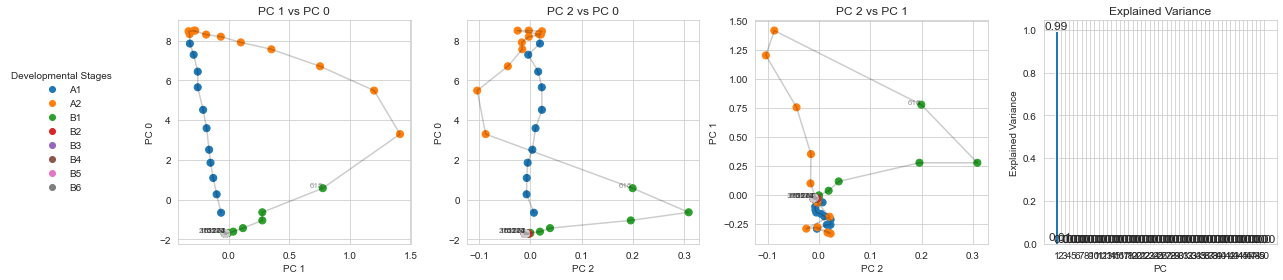

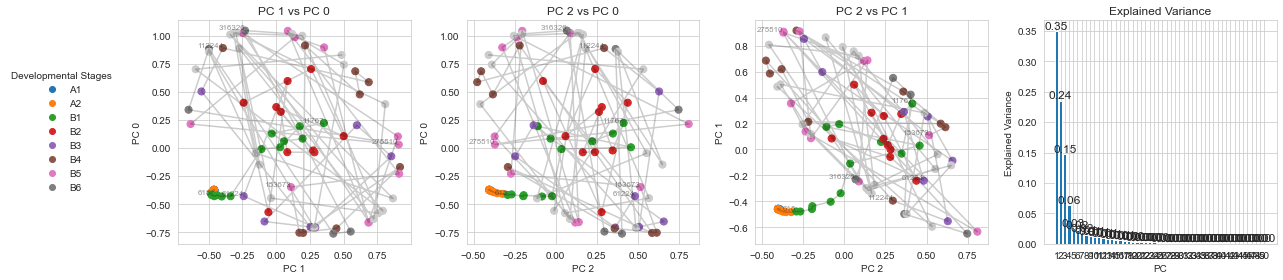

Exponentially averaged gradients
Unnormalized


/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


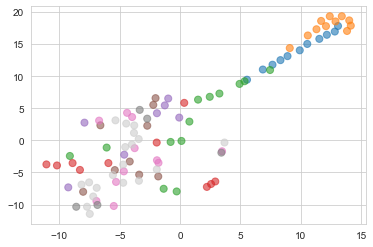

Normalized


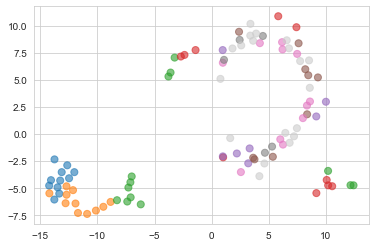

In [21]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del exp_avg_grads_over_time
    del exp_avg_grads_reduced
    del exp_avg_grads_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

exp_avg_grads_over_time = []
exp_avg_grads_normalized_over_time = []

def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])

def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


for i, opt_state in enumerate(optimizer_state_dicts):
    # model.train()
    exp_avg_grads = get_exp_avg_grads(opt_state)
    exp_avg_grads_over_time.append(exp_avg_grads)
    exp_avg_grads_normalized_over_time.append(exp_avg_grads / np.linalg.norm(exp_avg_grads))

exp_avg_grads_over_time = np.array(exp_avg_grads_over_time)
exp_avg_grads_normalized_over_time = np.array(exp_avg_grads_normalized_over_time)


pca_1 = PCA(n_components=50)
exp_avg_grads_reduced = pca_1.fit_transform(exp_avg_grads_over_time)

pca_2 = PCA(n_components=50)
exp_avg_grads_reduced_normalized = pca_2.fit_transform(exp_avg_grads_normalized_over_time)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :3], 
    pca_1, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced_normalized[:, :3], 
    pca_2, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plt.show()

print("Exponentially averaged gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne = tsne.fit_transform(exp_avg_grads_reduced)

plt.scatter(exp_avg_grads_tsne[:, 0], exp_avg_grads_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")

tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne_normalized = tsne.fit_transform(exp_avg_grads_reduced_normalized)

plt.scatter(exp_avg_grads_tsne_normalized[:, 0], exp_avg_grads_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

In [19]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del exp_avg_grads_over_time
    del exp_avg_grads_reduced
    del exp_avg_grads_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

exp_avg_grads_over_time = []
exp_avg_grads_normalized_over_time = []

def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])

def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


for i, opt_state in enumerate(optimizer_state_dicts):
    # model.train()
    exp_avg_grads = get_exp_avg_sq_grads(opt_state)
    exp_avg_grads_over_time.append(exp_avg_grads)
    exp_avg_grads_normalized_over_time.append(exp_avg_grads / np.linalg.norm(exp_avg_grads))

exp_avg_grads_over_time = np.array(exp_avg_grads_over_time)
exp_avg_grads_normalized_over_time = np.array(exp_avg_grads_normalized_over_time)

pca_1 = PCA(n_components=50)
exp_avg_grads_reduced = pca_1.fit_transform(exp_avg_grads_over_time)

pca_2 = PCA(n_components=50)
exp_avg_grads_reduced_normalized = pca_2.fit_transform(exp_avg_grads_normalized_over_time)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :3], 
    pca_1, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced_normalized[:, :3], 
    pca_2, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plt.show()

print("Exponentially averaged square gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne = tsne.fit_transform(exp_avg_grads_reduced)

plt.scatter(exp_avg_grads_tsne[:, 0], exp_avg_grads_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")
tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne_normalized = tsne.fit_transform(exp_avg_grads_reduced_normalized)

plt.scatter(exp_avg_grads_tsne_normalized[:, 0], exp_avg_grads_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

NameError: name 'highlight_steps' is not defined

In [ ]:

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
gradients_tsne = tsne.fit_transform(gradients_reduced)

plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)

## SGLD PCAs

In [ ]:
from pprint import pp
import sys

from icl.analysis.slt import ExpectedBatchLossEstimator
from icl.analysis.weights import WeightsTrace 
del sys.modules['icl.analysis.sample']
del sys.modules['icl.analysis.slt']
del sys.modules['icl.analysis.estimators']

import yaml
from icl.analysis.sample import SamplerConfig

os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')

CORES = 1
NUM_CHAINS = 25
NUM_DRAWS = 1000
NUM_SAMPLES = 1024
DATASET_SIZE = 2 ** 14

sampler_config: SamplerConfig = SamplerConfig(
    num_chains=NUM_CHAINS,
    num_draws=NUM_DRAWS,
    sampling_method='sgld',
    grad_batch_origin='eval-dataset',
    grad_batch_size=NUM_SAMPLES,
    noise_scale=5e-3,    
    localization_scale=5e-2,
    gradient_scale=1e-5 * 1024. / (2 * np.log(1024)), 
    # noise_scale=5e-4,    
    # localization_scale=1e-1,
    # gradient_scale=1e-6 * 1024. / (2 * np.log(1024)), 
    # eval_method='fixed-minibatch',
    eval_method='grad-minibatch',
    eval_metrics=['likelihood-derived', 'batch-loss', 'weights'],
    # eval_batch_size=8192,
    eval_dataset_size=DATASET_SIZE,
    device='cpu',
    cores=CORES,
    eval_loss_fn='mse',
    eval_online=True
)

print(yaml.dump(sampler_config.model_dump()))

run.model = models[-1]
run.model.to('cpu')
# log_fn = lambda data, step=None: print(f"Step: {step}\n", yaml.dump(data))
sampler = sampler_config.to_sampler(run, log_fn=None)
print("INIT LOSS", sampler.init_loss)

results = sampler.eval(run.model)

pp(sampler.callbacks[0].estimate())

In [ ]:
llc_callback = sampler.callbacks[0]
sgld_estimates_df = llc_callback.estimates()

sgld_estimates_df

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

batch_losses = sampler.batch_loss.estimates()
batch_losses['mean'] = [float(x) for x in batch_losses['mean']]

#llc_callback.expected_loss_estimator.
sns.lineplot(data=batch_losses, x="draw", y="mean", hue="chain", palette="gray", ax=ax, alpha=0.5)

twin_ax = ax.twinx()
sns.lineplot(data=sgld_estimates_df, x="draw", y="llc/mean", ax=twin_ax, alpha=0.5, color=PRIMARY)

ax.set_ylabel(r"Batch Loss. $L^{(\tau)}_m$")
twin_ax.set_ylabel(r"LLC, $\hat\lambda_\tau$", color=PRIMARY)
for label in twin_ax.get_yticklabels():
    label.set_color(PRIMARY)

ax.set_xlabel(r"Draw, $\tau$")
ax.legend().remove()


In [ ]:
init_weights_np = np.concatenate([p.view(-1).detach().cpu().numpy() for p in run.model.parameters()])

weights_np = sampler.callbacks[-1].weights.detach().cpu().numpy()[:, :, :]
# del sampler.callbacks[-1].weights

weights_flat = weights_np.reshape(-1, weights_np.shape[-1]) - init_weights_np

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
weights_reduced = pca.fit_transform(weights_flat)

# from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
weights_tsne = tsne.fit_transform(weights_reduced)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_explained_variance(pca, ax=ax)

In [ ]:
init_weights_np = np.concatenate([p.view(-1).detach().cpu().numpy() for p in run.model.parameters()])

weights_np = sampler.callbacks[-1].weights.detach().cpu().numpy()[:, :, :]
# del sampler.callbacks[-1].weights

weights_flat = weights_np.reshape(-1, weights_np.shape[-1]) - init_weights_np

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
weights_reduced = pca.fit_transform(weights_flat)

# from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
weights_tsne = tsne.fit_transform(weights_reduced)

In [ ]:
for chain in range(NUM_CHAINS):
    _weights = weights_tsne[chain * NUM_DRAWS:(chain + 1) * NUM_DRAWS] 
    sns.scatterplot(x=_weights[:, 0], y=_weights[:, 1], s=50, alpha=0.6)

In [ ]:
import itertools

def plot_weights_trace_fn(model, deltas, xs, ys, device='cpu', num_components=3, num_points=10):
    model.to(device)
    xs.to(device)
    ys.to(device)

    num_chains = deltas.shape[0]
    num_draws = deltas.shape[1]


    pca = PCA(n_components=num_components)

    weights_reduced = pca.fit_transform(deltas.reshape(num_chains * num_draws, -1))

    def get_pc_landscape(pca, fn, pc1, pc2, pc1_lim: Tuple[int, int], pc2_lim: Tuple[int, int], num_points=100, ax=None):
        xx, yy = np.meshgrid(np.linspace(*pc1_lim, num_points), np.linspace(*pc2_lim, num_points))

        # Compute function values for the grid
        Z = np.zeros(xx.shape)
        for i in tqdm.tqdm(range(xx.shape[0]), "Iterating over rows"):
            for j in range(xx.shape[1]):
                u = xx[i, j] * pc1 + yy[i, j] * pc2
                Z[i, j] = fn(u)

        # Plot the density map
        Z = (Z - Z.min()) / (Z.max() - Z.min()) # rescale
        Z = np.log(1e-3 + Z)
        
        im = ax.imshow(Z, interpolation='bilinear', origin='lower',
            extent=(*pc1_lim, *pc2_lim), cmap='Blues', alpha=1., aspect='auto')
        
        return Z

    def weights_to_model(weights):
        m = deepcopy(model)
        m.to(device)

        i = 0
        for n, p in m.named_parameters():
            p.data += torch.from_numpy(weights[i:i+p.numel()]).view(p.shape).to(device)
            i += p.numel()
        
        return m


    def weights_to_loss(weights):
        m = weights_to_model(weights)
        yhats = m(xs, ys)
        return F.mse_loss(yhats, ys).item()

    xs.to(device)
    ys.to(device)

    pc_combos = list(itertools.combinations(range(num_components), 2))

    fig, axes = plt.subplots(1, len(pc_combos) + 1, figsize=(20, 5))

    for ax,  (pc1_idx, pc2_idx) in zip(axes, pc_combos):
        pc1 = pca.components_[pc1_idx]
        pc2 = pca.components_[pc2_idx]

        min_pc1, max_pc1 = weights_reduced[:, pc1_idx].min(), weights_reduced[:, pc1_idx].max()
        min_pc2, max_pc2 = weights_reduced[:, pc2_idx].min(), weights_reduced[:, pc2_idx].max()

        pc1_lims = (min_pc1 - 0.1 * (max_pc1 - min_pc1), max_pc1 + 0.1 * (max_pc1 - min_pc1))
        pc2_lims = (min_pc2 - 0.1 * (max_pc2 - min_pc2), max_pc2 + 0.1 * (max_pc2 - min_pc2))

        get_pc_landscape(pca, weights_to_loss, pc1, pc2, pc1_lims, pc2_lims, num_points=num_points, ax=ax)

        for chain in range(num_chains):
            # _weights = pca.transform(deltas[chain])
            _weights = weights_reduced[chain * num_draws:(chain + 1) * num_draws] 
            sns.scatterplot(x=_weights[:, pc1_idx], y=_weights[:, pc2_idx], ax=ax, s=2, alpha=0.2)

        ax.set_xlim(*pc1_lims)
        ax.set_ylim(*pc2_lims)

        ax.set_title(f"PC {pc1_idx + 1} vs PC {pc2_idx + 1}")
        ax.set_xlabel(f"PC {pc1_idx + 1}")
        ax.set_ylabel(f"PC {pc2_idx + 1}")

    # Plot explained variance
    plot_explained_variance(pca, title="Explained Variance", ax=axes[-1])        


plot_weights_trace_fn(run.model, sampler.weights.deltas(), xs=xs, ys=ys, device=DEVICE, num_components=4, num_points=10)

In [ ]:
torch.mps.current_allocated_memory() / 1e9


## Gradient clustering

## Per-token LLCs

## Per-token Essential Dynamics

# Structural indicators

## Parametric Essential Dynamics

In [ ]:
# Let's try this for restricted subsets of weights as well

from typing import Callable


def extract_weights_over_checkpoints(models: Iterable[nn.Module], extract_weights: Callable = lambda m: [p.flatten() for p in m.parameters()], normalize=False):
    for model in models:
        weights = torch.cat(extract_weights(model)).detach().cpu().numpy()

        if normalize:
            weights /= np.linalg.norm(weights)

        yield weights



def get_pca_weights_trace(models: Iterable[nn.Module], extract_weights: Callable = lambda m: [p.flatten() for p in m.parameters()], num_components=3, normalize=False) -> Dict[str, Tuple[PCA, np.ndarray]]:
    weights = np.array([w for w in extract_weights_over_checkpoints(models, extract_weights, normalize=normalize)])

    pca = PCA(n_components=num_components)
    weights_reduced = pca.fit_transform(weights)

    return weights_reduced, pca

all_weights, weights_pca = get_pca_weights_trace(models, num_components=3, normalize=False)

plot_multiple_slices(
    steps, 
    all_weights, 
    weights_pca, 
    highlight_steps,
    transitions_of_steps,
    connect_dots=True, 
    title=run.config.to_latex(), 
    save=None,
)
plt.show()


In [ ]:
extract_embedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.token_embedding.parameters()]
extract_unembedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.unembedding[1].parameters()]
extract_embedding_unembedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.token_embedding.parameters()] + [p.flatten() for p in m.token_sequence_transformer.unembedding[1].parameters()]
extract_block_0_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].parameters()]
extract_block_1_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].parameters()]
extract_lns = lambda m: [m.state_dict()[f"{ln}.{part}"] for ln in layer_norms for part in ["weight", "bias"]]
extract_mlp_0 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].compute[0].parameters()] + [p.flatten() for p in m.token_sequence_transformer.blocks[0].compute[2].parameters()]
extract_mlp_1 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].compute[0].parameters()] + [p.flatten() for p in m.token_sequence_transformer.blocks[1].compute[2].parameters()]
extract_attn_0 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].attention.attention.parameters()]
extract_attn_1 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].attention.attention.parameters()]

extract_weights_fns = {
    "Embedding & Unembedding": extract_embedding_unembedding_weights, 
    "Unembedding": extract_unembedding_weights, 
    "Embedding": extract_embedding_weights, 
    "Block 0": extract_block_0_weights, 
    "Block 1": extract_block_1_weights, 
    "Layer norms": extract_lns,
    "MLP 0": extract_mlp_0,
    "MLP 1": extract_mlp_1,
    "Attention 0": extract_attn_0,
    "Attention 1": extract_attn_1,
}

for label, extract_weights in extract_weights_fns.items():
    print(label)

    for normalize in [False, True]:
        print(f"Normalize: {normalize}")
        subset_weights, weights_pca = get_pca_weights_trace(models, num_components=3, extract_weights=extract_weights, normalize=normalize)

        plot_multiple_slices(
            steps, 
            subset_weights, 
            weights_pca, 
            highlight_steps,
            transitions_of_steps,
            connect_dots=True, 
            title=run.config.to_latex(), 
            save=None,
        )
        plt.show()



## Embedding

In [ ]:
steps = run.checkpointer.file_ids
embedding_matrices = []  # Shape: (64, 5): 64 vectors x (1 y dim + 4 x dims)

for model in models:
    embedding_matrices.append(model.state_dict()['token_sequence_transformer.token_embedding.weight'])


embedding_vec_x_norms = [vec.norm(dim=1) for vec in embedding_matrices]  # (64,)

In [ ]:
# PCA explained Variance over time
pcas = []

for model in models:
    embed = model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()
    pca = PCA(n_components=embed.shape[1])
    proj = pca.fit_transform(embed)[:,:3]
    pcas.append((proj, pca))

explained_variances = [{"value": value, "index": idx, "step": step} for step, (_, pca) in zip(steps, pcas) for idx, value in enumerate(pca.explained_variance_ratio_)]
explained_variances = pd.DataFrame(explained_variances)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')
ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step, $t$")

plot_transitions(ax, TRANSITIONS, limit=True)

In [ ]:
# Using the final PCA

def compute_explained_variance(pca, embed):
    proj = pca.transform(embed)

    # Step 4 and 5: Compute variance of projected data and total variance
    variance_projected = np.var(proj, axis=0)
    total_variance = np.sum(variance_projected)

    # Step 6: Calculate explained variance ratio
    explained_variance_ratio = variance_projected / total_variance

    return explained_variance_ratio

explained_variances_rel_last_pca = [{"value": value, "index": idx, "step": step} for step, embed in zip(steps, embedding_matrices) for idx, value in enumerate(compute_explained_variance(pcas[-1][-1], embed.detach().cpu().numpy()))]
explained_variances_rel_last_pca = pd.DataFrame(explained_variances_rel_last_pca)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances_rel_last_pca, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')

ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step, $t$")

plot_transitions(ax, TRANSITIONS, limit=True)

In [ ]:
# Let's project embedding vectors onto these pca components and track their evolution
last_pca = pcas[-1][-1]
transformed = [last_pca.transform(embed.detach().cpu().numpy()) for embed in embedding_matrices]
transition_middles = [get_nearest_step((t[0] + t[1]) * 0.5) for t in TRANSITIONS]

fig, axes = plt.subplots(1, len(transition_middles), figsize=(20, 5))

min_x, max_x = 0, 0
min_y, max_y = 0, 0

for ax, middle in zip(axes, transition_middles):
    middle_idx = steps.index(middle)
    middle_embeddings = transformed[middle_idx]
    sns.scatterplot(data=pd.DataFrame(middle_embeddings), x=0, y=1, ax=ax)
    ax.set_title(f"Step {middle}")

    min_x = min(min_x, middle_embeddings[:, 0].min())
    max_x = max(max_x, middle_embeddings[:, 0].max())
    min_y = min(min_y, middle_embeddings[:, 1].min())
    max_y = max(max_y, middle_embeddings[:, 1].max())

for ax in axes:
    ax.set_xlim(min_x * 1.25, max_x * 1.25)
    ax.set_ylim(min_y * 1.25, max_y * 1.25)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming 'pcas', 'embedding_matrices', 'TRANSITIONS', and 'steps' are defined as in your context.

last_pca = pcas[-1][-1]
transformed = [last_pca.transform(embed.detach().cpu().numpy()) for embed in embedding_matrices]
transition_middles = [get_nearest_step((t[0] + t[1]) * 0.5) for t in TRANSITIONS]

min_x, max_x = min([t[:, 0].min() for t in transformed]), max([t[:, 0].max() for t in transformed])
min_y, max_y = min([t[:, 1].min() for t in transformed]), max([t[:, 1].max() for t in transformed])

# Set up the figure.
fig, ax = plt.subplots(figsize=(8, 6))
plt.xlim(min_x * 1.25, max_x * 1.25)
plt.ylim(min_y * 1.25, max_y * 1.25)
scat = ax.scatter([], [])

# Update function for the animation.
def update(frame):
    middle_embeddings = transformed[frame]
    ax.clear()
    ax.set_xlim(min_x * 1.25, max_x * 1.25)
    ax.set_ylim(min_y * 1.25, max_y * 1.25)
    ax.set_title(f"Step {steps[frame]}")
    sns.scatterplot(data=pd.DataFrame(middle_embeddings), x=0, y=1, ax=ax)

# Create the animation.
ani = FuncAnimation(fig, update, frames=range(len(steps)), repeat=False)

# To save the animation, you can use the following line:
ani.save(FIGURES / 'M1-embed.mp4', writer='ffmpeg', fps=1)

plt.show()


## Zero ablations

In [ ]:
# W_U, W_E gives us a 5x5 matrix
# The rows act, respectively, on y, and the x components. 
# So we can see what the cossim of these vectors is with the task vector. 

task = run.pretrain_dist.task_distribution.tasks[0]
task_np = task.detach().cpu().numpy()
task_embed = np.zeros(5)
task_embed[1:] = task_np
print(task_np)

embed_unembed = [
    model.token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy() @ model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()
    for model in models
]

cossims = [
    (v @ task_embed) / (np.linalg.norm(v) * np.linalg.norm(task_embed)) for v in embed_unembed
]

norm_ratio = [
    np.linalg.norm(v, axis=0) / np.linalg.norm(task_embed) for v in embed_unembed
]


fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
ax.plot(run.checkpointer.file_ids, cossims, label=["$y$", "$x_1$", "$x_2$", "$x_3$", "$x_4$"])
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel(r"Cosine similarity between $(W_U W_E)_i$ and $\mathbf{t}$")
ax.set_title("$W_U W_E$ over time")

ax.legend(loc='lower left')
ax.legend()

ax = axes[1]
ax.plot(run.checkpointer.file_ids, norm_ratio)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel(r"$\|(W_U W_E)_i\| / \|\mathbf{t}\|$")

plot_transitions(axes, TRANSITIONS, limit=True)

fig.set_facecolor('white')


In [ ]:

bias_stats = []

for step, model in zip(steps, models):
    state_dict = model.state_dict()

    bias_stats.append({
        "step": step,
        "postn_embedding_norm": state_dict["token_sequence_transformer.postn_embedding.weight"].norm().item(),
        "unembedding_ln_bias_norm": state_dict["token_sequence_transformer.unembedding.0.bias"].norm().item(),    
    })

bias_stats = pd.DataFrame(bias_stats)

In [ ]:
postn_embeddings = []
unembedding_biases = []

for step, model in zip(steps, models):
    state_dict = model.state_dict()

    _postn_embedding = state_dict["token_sequence_transformer.postn_embedding.weight"]

    for i, p in enumerate(_postn_embedding):
        postn_embeddings.append({
            "step": step,
            "postn_embedding_0": p[0].item(),
            "idx": i,
            "postn_embedding_x_std": p[::2].std().item(),
            "postn_embedding_x_mean": p[::2].mean().item(),
            "postn_embedding_y_std": p[1::2].std().item(),
            "postn_embedding_y_mean": p[1::2].mean().item(),
        })

    _unembedding_bias = state_dict["token_sequence_transformer.unembedding.0.bias"]
    for i, p in enumerate(_unembedding_bias):
        unembedding_biases.append({
            "step": step,
            "unembedding_bias": p.item(),
            "idx": i
        })

postn_embeddings = pd.DataFrame(postn_embeddings)
unembedding_biases = pd.DataFrame(unembedding_biases)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 2))

axes[0].matshow(models[-1].token_sequence_transformer.postn_embedding.weight[:, ::2].T.detach().cpu().numpy(), aspect="auto")
axes[1].matshow(models[-1].token_sequence_transformer.postn_embedding.weight[:, 1::2].T.detach().cpu().numpy(), aspect="auto")

plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

ax.matshow(models[-1].token_sequence_transformer.unembedding[0].bias.reshape((1, 64)).detach().cpu().numpy(), aspect="auto")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
# sns.lineplot(data=bias_stats, x="step", y="postn_embedding_norm", ax=ax)
sns.lineplot(data=postn_embeddings, x="step", y="postn_embedding_0", hue="idx", palette="gray", ax=ax, alpha=0.5)

ax.set_xscale("log")

ax = axes[1]
# sns.lineplot(data=bias_stats, x="step", y="unembedding_ln_bias_norm", ax=ax)
sns.lineplot(data=unembedding_biases, x="step", y="unembedding_bias", hue="idx", palette="gray", ax=ax, alpha=0.5)
ax.set_xscale("log")

plot_transitions(axes, TRANSITIONS, limit=True)

In [ ]:
from matplotlib import patches
from icl.model import to_token_sequence, from_predicted_token_sequence

class EmbedUnembedOnlyV2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) # + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        x = self.unembedding[0](x)
        unembedded = self.unembedding[1](x)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


# embed_unembed_only_model = EmbedUnembedOnly(run.model)

def get_embed_unembed_with_bias(model, multiplier=1.):
    eu_model = EmbedUnembedOnlyV2(model).to('cpu')

    w = np.zeros(4)
    basis = torch.eye(4, device="cpu") * multiplier
    ys = torch.zeros(1, 1, 1, device="cpu") 

    for i in range(4):
        w[i] = eu_model(basis[i].unsqueeze(0).unsqueeze(0), ys)[0].item()

    return w


embed_unembed_with_bias = [
    get_embed_unembed_with_bias(model, 10)
    for model in models
]

print(embed_unembed_with_bias[0].shape, task_embed.shape)

cossims = [
    (v @ task_np) / (np.linalg.norm(v) * np.linalg.norm(task_np)) for v in embed_unembed_with_bias
]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(run.checkpointer.file_ids, cossims)
ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_ylabel(r"Cosine similarity with $w_1$")
ax.set_title("Effective weight using only embedding (token only), unembedding (linear only), with biases")

# plt.legend(loc='lower left')
plot_transitions(ax, TRANSITIONS)
fig.set_facecolor('white')

## Layer norms

In [ ]:
from icl.analysis.slt import prepend_keys

layer_norms = [
    "token_sequence_transformer.unembedding.0",
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.layer_norms.1",
]

list(model.state_dict().keys())

def get_ln(model, key):
    return (model.state_dict()[f'{key}.weight'], model.state_dict()[f'{key}.bias'])

unembed_lns = [get_ln(model, 'token_sequence_transformer.unembedding.0') for model in models]
block_1_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.0') for model in models]
block_1_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.1') for model in models]
block_2_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.0') for model in models]
block_2_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.1') for model in models]

def ln_norm(weight, bias):
    return torch.norm(weight).detach().cpu().numpy()

def ln_norm_std(weight, bias):
    return torch.std(weight.abs()).detach().cpu().numpy()

unembed_ln_norms = [ln_norm(weight, bias) for weight, bias in unembed_lns]
block_1_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_mlp_lns]

unembed_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in unembed_lns])
block_1_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_attn_lns])
block_1_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_mlp_lns])
block_2_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_attn_lns])
block_2_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_mlp_lns])

def frac_nonzero(weight, eps=1e-1):
    return (weight.abs() > eps).float().mean().detach().cpu().numpy()

unembed_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in unembed_lns]
block_1_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_mlp_lns]

ln_stats = []

def get_stats(weight):
    return {
        "norm": weight.norm().item(),
        "norm_std": weight.abs().std().item(),
        "std": weight.std().item(),
        "mean": weight.mean().item(),
        "max": weight.max().item(),
        "min": weight.min().item(),
    }
    

for step, model in zip(steps, models):
    for layer in ["unembed", "block_1_attn", "block_1_mlp", "block_2_attn", "block_2_mlp"]:
        weight, bias = get_ln(model, f"token_sequence_transformer.{layer}.0")

        ln_stats.append({
            "step": step,
            "layer": layer,
            "layer_pretty": layer.replace("_", " ").title(),
            **prepend_keys(get_stats(weight), "weight/"),
            **prepend_keys(get_stats(bias), "bias/"),
        })

ln_stats = pd.DataFrame(ln_stats)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=ln_stats, x="step", y="norm", hue="layer", palette="deep", ax=ax)

# Fill between using the std
for layer in ["unembed", "block_1_attn", "block_1_mlp", "block_2_attn", "block_2_mlp"]:
    ax.fill_between(steps, eval(f"{layer}_ln_norms") - eval(f"{layer}_ln_norms_std"), eval(f"{layer}_ln_norms") + eval(f"{layer}_ln_norms_std"), alpha=0.2)

ax.legend(title="Layer", loc='lower left')
plot_transitions(ax, TRANSITIONS)
ax.set_title("Layer Norm Weight Norms over Time")
ax.set_xscale('log')
ax.set_xlim(100, 500_000)

In [ ]:
labels = ["Unembed", "Block 1 Attn", "Block 1 MLP", "Block 2 Attn", "Block 2 MLP"]

for i, lns in enumerate([unembed_lns, block_1_attn_lns, block_1_mlp_lns, block_2_attn_lns, block_2_mlp_lns]):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    label = labels[i]
    lns_df = pd.DataFrame([{"step": step, "idx": i, "weight": weight.item(), "bias": bias.item()} for step, (weights, biases) in zip(steps, lns) for i, (weight, bias) in enumerate(zip(weights, biases))])

    ax = axes[0]
    # inset_ax_1 = ax.inset_axes([0.1, 0.1, 0.4, 0.4])

    sns.lineplot(data=lns_df, x="step", y="weight", color=PRIMARY, ax=ax)
    # sns.lineplot(data=lns_df, x="step", y="weight", hue="idx", palette="gray", ax=inset_ax_1, alpha=0.1)
    ax.set_title(f"{label} Layer Norm Weights over Time")
    ax.set_ylabel("$u_i$")
    ax.set_xlim(100, 500_000)
    
    ax = axes[1]
    # inset_ax_2 = ax.inset_axes([0.1, 0.1, 0.4, 0.4])

    sns.lineplot(data=lns_df, x="step", y="bias", color=PRIMARY, ax=ax)
    # sns.lineplot(data=lns_df, x="step", y="bias", hue="idx", palette="gray", ax=inset_ax_2, alpha=0.1)
    ax.set_title(f"{label} Layer Norm Biases over Time")
    ax.set_ylabel("$\mathrm{unembed bias}_i$")
    ax.set_xlim(100, 500_000)
    
    plot_transitions(axes, TRANSITIONS, limit=True)
    plot_transitions(np.array([inset_ax_1, inset_ax_2]), TRANSITIONS, limit=True)

    for ax in axes:
        ax.set_xlabel("Step, $t$")
        ax.set_xscale('log')
        
    # for ax in [inset_ax_1, inset_ax_2]:
    #     ax.legend().remove()

    # for ax in [*axes, inset_ax_1, inset_ax_2]:
    #     ax.set_xscale('log')



    plt.show()


## Residual stream

In [ ]:
# act_stats_over_time = act_stats_over_time[act_stats_over_time["step"] > 0]

resid_stream_layers = [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.blocks.0.resid_after_attn",
    "token_sequence_transformer.blocks.0",
    "token_sequence_transformer.blocks.1.resid_after_attn",
    "token_sequence_transformer.blocks.1"
]

try: 
    del act_stats_over_time
except NameError:
    pass

act_stats_over_time = []

for step, model in zip(steps, models):
    hooked_model = hook(model)
    output, act = hooked_model.run_with_cache(xs, ys)

    for layer in resid_stream_layers:
        #print(act[layer].shape)
        act_stats_over_time.append({
            'mean': act[layer].mean().item(),  # mean over batch, over tokens, over activations
            'abs_mean': act[layer].mean(dim=-1).abs().mean().item(),  # mean over batch and tokens of abs mean over activations
            'var': act[layer].var().item(),  # var over batch, over tokens, over activations
            'batch_var_of_mean': act[layer].var(dim=-1).mean().item(),  # mean over batch and tokens of var over activations
            'batch_var_of_var': act[layer].var(dim=-1).var().item(),  # var over batch and tokens of var over activations
            'max': act[layer].max().item(),
            'min': act[layer].min().item(),
            "step": step, 
            "layer": layer,
            "layer_idx": resid_stream_layers.index(layer),
            "dim46": act[layer][:, :, 46].abs().mean().item(),
            "dim51": act[layer][:, :, 51].abs().mean().item(),
        })

act_stats_over_time = pd.DataFrame(act_stats_over_time)

In [ ]:
more_metrics_to_plot = [
    ("$\overline{|\mathrm{mean}[z^{(l)}_t]|}$", "abs_mean", {}),
#    ("Mean over batch, token index, and activation index of residual stream activations", "std", {}),
    ("$\overline{\mathrm{var}[z^{(l)}_t]}$", "batch_var_of_mean", {}),
#    ("Std over batch and token index of std within residual stream activations", "batch_std_of_std", {}),
#    ("Dim 46", "dim46", {}),
#    ("Dim 51", "dim51", {}),
]

layers = act_stats_over_time["layer"].unique()
slopes = np.zeros((len(layers), len(run.checkpointer.file_ids[1:])))

slopes_list = []

for (_, key, _) in more_metrics_to_plot:
    for j, layer in enumerate(layers):
        values = act_stats_over_time.loc[act_stats_over_time["layer"] == layer][key].values
        slopes[j, :] = dlog_dlogt(run.checkpointer.file_ids[1:], values)

    slopes_list.extend([{"layer": layer, "step": step, key: slopes[j, step_idx]} for j, layer in enumerate(layers) for step_idx, step in enumerate(run.checkpointer.file_ids[1:]) for slope in slopes])

slopes_df = pd.DataFrame(slopes_list)

In [ ]:
fig, axes = plt.subplots(1, len(more_metrics_to_plot), figsize=(20, 6))

# act_stats_over_time = act_stats_over_time[act_stats_over_time["step"] > 0]

for i, (ax, (metric_name, key, kwargs)) in enumerate(zip(axes, more_metrics_to_plot)):
    sns.lineplot(ax=ax, data=act_stats_over_time, x="step", y=key, hue='layer', palette='viridis')

    ax.set_title(metric_name + " over Time")
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(metric_name)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend().remove()

    # sns.lineplot(ax=axes[1, i], data=slopes_df, x="step", y=key, hue='layer', palette='viridis')
    # axes[1, i].set_title(metric_name + " Slope over Time")
    # axes[1, i].set_xlabel('Time Steps')
    # axes[1, i].set_ylabel(metric_name + " Slope")

plot_transitions(axes, TRANSITIONS, limit=True)

for ax in axes[:2].flatten():
    pass


fig.tight_layout()
fig.set_facecolor("white")

# axes[1, 0].set_ylim(-10, 10)
# axes[1, 1].set_ylim(-5, 5)

# Show the plots
plt.show()


## Attention Entropies

In [ ]:
from collections import defaultdict
from typing import List, Union, Iterable, Optional
from torchtyping import TensorType
from devinfra.utils.iterables import map_nested

from icl.experiments.utils import iter_models
from devinfra.utils.iterables import flatten_dict

from icl.train import Run

def compute_attention_entropies(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the entropy of each token in each head, averaged across the batch, 
    then averages this over heads. 

    """
    
    # Threshold attention weights to avoid log(0)
    log_attention = torch.where(attn > 0, torch.log(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1) # TensorType["H", "2K"]

    num_heads, num_tokens = entropy_per_token.shape

    entropy_per_head = entropy_per_token.mean(dim=-1) # TensorType["H"]
    entropy = entropy_per_head.mean() # TensorType[]    
    
    # Each token computes entropy over a variable context length, so we normalize by the maximum possible entropy
    # for a token with a fixed context length.

    max_entropy_per_token = torch.log2(torch.arange(1, num_tokens + 1).to(attn.device)) # TensorType["H", "2K"]
    max_entropy_per_token[0] = 1. # Special case for the first token to avoid dividing by 0

    entropy_per_token_normalized = entropy_per_token / max_entropy_per_token
    entropy_per_head_normalized = entropy_per_token_normalized.mean(dim=-1) # TensorType["H"]
    entropy_normalized = entropy_per_head_normalized.mean() # TensorType[]    

    results: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]] = {"mean": entropy, "mean_normalized": entropy_normalized}

    for i in range(num_heads):
        head_results = {"mean": entropy_per_head[i], "mean_normalized": entropy_per_head_normalized[i]}

        for j in range(num_tokens):
            head_results[f"token_{j}"] = entropy_per_token[i, j]
            head_results[f"token_{j}_normalized"] = entropy_per_token_normalized[i, j]

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_entropies_trace(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            path = reverse_paths[k]
            results[path].append(compute_attention_entropies(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)


num_blocks = run.config.task_config.num_layers
num_heads = run.config.task_config.num_heads
num_tokens = run.config.task_config.max_examples * 2


attn_entropies = get_attention_entropies_trace(
    run.checkpointer.file_ids,
    models, 
    xs, 
    ys, 
    **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
)

# run_attn_entropy_slug = "attn-S-" + run.config.to_slug(delimiter="-")


In [ ]:
def plot_attention_patterns(df: pd.DataFrame, num_blocks: int, num_heads: int, num_tokens: int, title="", save: Optional[str] = None, normalized=False, figsize=(20, 25), logx=False, logy=False):
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title)

    num_cols = num_blocks * 2
    num_rows = 1 + 1 + num_heads

    suffix = "" if not normalized else "_normalized"
    suffix_title = "" if not normalized else " (Normalized)"

    fig.set_facecolor('white')

    # Create subplot for mean entropy of first two blocks
    ax0 = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
    block_cmap = sns.color_palette("viridis", num_blocks)

    for b in range(num_blocks):
        ax0.plot(df.step, df[f"block_{b}/mean{suffix}"], label=f"block_{b}", color=block_cmap[b])

    ax0.set_title("Blocks")
    ax0.set_xlabel("Step")
    ax0.set_ylabel(f"Entropy{suffix_title}")
    ax0.legend()

    plot_transitions(ax0, TRANSITIONS, limit=True)

    # Create subplots for each block, showing entropy in different heads
    ax1 = [plt.subplot2grid((num_rows, num_cols), (1, i*2), colspan=2) for i in range(num_blocks)]
    head_cmap = sns.color_palette("viridis", num_heads)
    
    for b in range(num_blocks):
        ax1[b].set_title(f"Block {b}")
        ax1[b].set_xlabel("Step")
        ax1[b].set_ylabel(f"Entropy{suffix_title}")
        for h in range(num_heads):
            series = df[f"block_{b}/head_{h}/mean{suffix}"]
            ax1[b].plot(df.step, series, label=f"Head {h}", color=head_cmap[h])

    ax1[0].legend()

    plot_transitions(ax1, TRANSITIONS, limit=True)

    # Create subplots for each head in each block, detailing entropy for each token
    ax2 = [plt.subplot2grid((num_rows, num_cols), (i//(num_cols) + 2, i%(num_cols))) for i in range(num_heads * num_blocks * 2)]
    ax_idx = 0
    token_cmap = sns.color_palette("viridis", num_tokens)


    for h in range(num_heads):
        for b in range(num_blocks):
            for x_or_y in (1, 0):
                ax2[ax_idx].set_title(f"Block {b} Head {h}")
                ax2[ax_idx].set_xlabel("Step")
                ax2[ax_idx].set_ylabel(f"Entropy{suffix_title}")

                for t in range(1-int(x_or_y), num_tokens, 2):
                    series = df[f"block_{b}/head_{h}/token_{t}{suffix}"]
                    ax2[ax_idx].plot(df.step, series, label=f"Token {t}", color=token_cmap[t])
                    
                ax_idx += 1

    ax2[0].legend()
    ax2[1].legend()

    plot_transitions(ax2, TRANSITIONS, limit=True)

    for ax in [ax0, *ax1, *ax2]:
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


In [ ]:
for normalized in (True, False):
    plot_attention_patterns(
        attn_entropies, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=run.config.to_latex(), 
        save=FIGURES / (f"{MODEL_ID}-attn-entropy-normalized-{normalized}" + ".png"),
        figsize=(25, 25),
        normalized=normalized,
        logx=True,
    )

# Mechanistic Interpretability

In [ ]:
from typing import List
from torchtyping import TensorType


def get_attention(model, xs, ys):
    num_layers = len(model.token_sequence_transformer.blocks)
    probes = []

    for b in range(num_layers):
        probe = ActivationProbe(model, f"token_sequence_transformer.blocks.{b}.attention.attention_softmax")
        probe.register_hook()
        probes.append(probe)

    # Run the model
    model(xs, ys)

    for probe in probes:
        probe.unregister_hook()

    # Get the activations
    return [probe.activation for probe in probes]

def plot_activations(activations: List[TensorType["batch", "heads", "tokens", "tokens"]]):       
    num_layers = len(activations)
    num_samples, num_heads, num_tokens, _ = activations[0].shape

    for sample_idx in range(num_samples):
        # Create a new figure
        plt.figure(figsize=(15, 4 * num_layers))

        # Loop through each head
        for layer_idx, activation in enumerate(activations):
            for head_idx in range(num_heads):
                head_activation = activation[sample_idx, head_idx].detach().cpu().numpy()

                # Create a subplot for each head
                ax = plt.subplot(num_layers, num_heads, layer_idx * num_heads + head_idx + 1)

                # Plot the activation
                ax.imshow(head_activation, cmap='viridis', aspect='auto')

                # Add title and labels
                ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
                ax.set_xlabel('Keys')
                ax.set_ylabel('Queries')

        plt.tight_layout()
        plt.show()

def compose2(f, g):
    return lambda *a, **kw: f(g(*a, **kw))

def compose(*fs):
    from functools import reduce
    return reduce(compose2, fs)

get_and_plot_activations = compose(plot_activations, get_attention)

In [ ]:
ws = run.pretrain_dist.task_distribution.tasks
print(ws)

In [ ]:
from icl.tasks import apply_transformations

# x_trick = torch.zeros((4, 8, 4))
# x_trick[:, :, 0] = torch.arange(0, 8)
# # y_trick = torch.zeros((1, 8, 1))
# x_trick = x_trick.to("mps")
# y_trick = apply_transformations(ws, x_trick, run.pretrain_dist.std, device="mps")

x_trick = torch.zeros((4, 8, 4))
for i in range(4):
    x_trick[i, :, i] = torch.arange(0, 8)

# y_trick = torch.zeros((1, 8, 1))
x_trick = x_trick.to("mps")
y_trick = apply_transformations(ws[0].repeat(4), x_trick, run.pretrain_dist.std, device="mps")

for i in range(4):
    plt.matshow(x_trick[i].T.detach().cpu().numpy())

plt.matshow(y_trick.detach().cpu().numpy())

In [ ]:
# xs, ys = run.pretrain_dist.get_batch(8, 1)
# get_and_plot_activations(run.model, xs=xs, ys=ys)
get_and_plot_activations(run.model, xs=x_trick, ys=y_trick)

In [ ]:
run_2 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 65536, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_2, ys_2 = run_2.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_2.model, xs=xs_2, ys=ys_2)
get_and_plot_activations(run_2.model, xs=x_trick, ys=y_trick)

In [ ]:
run_3 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 64, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_3, ys_3 = run_3.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_3.model, xs=xs_3, ys=ys_3)
get_and_plot_activations(run_3.model, xs=x_trick, ys=y_trick)

In [ ]:
import numpy as np
from icl.model import from_predicted_token_sequence, to_token_sequence

activations = []

class EmbedUnembedOnly(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        # unembedded = self.unembedding[0](x)
        unembedded = self.unembedding[1](x / 25)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


embed_unembed_only_model = EmbedUnembedOnly(run.model)
run.evaluator(embed_unembed_only_model)

In [ ]:
hooked_model = hook(run.model)

In [ ]:
activations = hooked_model.run_with_cache(run.evaluator.pretrain_xs, run.evaluator.pretrain_ys)[1]
activations.keys()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
plt.suptitle("Residual Stream Activations")

for ax, activation, label in zip(axes, activations, ["Embedding", "Block 1", "Block 2"]):
    cax = ax.matshow(activation)
    ax.set_title(f"After {label}")
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Token")
    fig.colorbar(cax, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:

def separate_attention(qkv, num_heads, batch_size, head_size, num_tokens):
    return (qkv.view(batch_size, num_tokens, num_heads, 3*head_size)
            .transpose(-2, -3)
            .split(head_size, dim=-1))

def plot_matrix(ax, data, title: Optional[str] = None):
    ax.matshow(data.detach().to("cpu").numpy())
    ax.grid(None)

    if title is not None:
        ax.set_title(title)

def plot_attention(axs, data, titles, num_heads):
    q, k, softmax, v  = data
    qk = (q.unsqueeze(0) @ k.unsqueeze(0).transpose(-2, -1))[0]

    # Rows for each head
    # Columns for Q, K, QK, V
    for j, (name, x) in enumerate(zip(titles, [q, k, qk, softmax, v])):
        axs[0, j].set_title(name)

        for h in range(num_heads):
            plot_matrix(axs[h, j], x[h])

    for h in range(num_heads):
        axs[h, 0].set_ylabel(f"Head {h}")


fig, axes = plt.subplots(4, 5, figsize=(15, 15))
softmax = activations["token_sequence_transformer.blocks.0.attention.attention_softmax"]
q, k, v = separate_attention(activations["token_sequence_transformer.blocks.0.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)
attn = [q[0], k[0], softmax[0], v[0]]
plot_attention(axes, attn, ["Q", "K", "QK", "softmax", "V"], num_heads=4)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

softmax0 = activations["token_sequence_transformer.blocks.0.attention.attention_softmax"][0]
v0 = separate_attention(activations["token_sequence_transformer.blocks.0.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)[-1][0]

softmax1 = activations["token_sequence_transformer.blocks.1.attention.attention_softmax"][0]
v1 = separate_attention(activations["token_sequence_transformer.blocks.1.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)[-1][0]

labels = ["Block 1 Attention Patterns", "Block 1 Value Matrices", "Block 2 Attention Patterns", "Block 2 Value Matrices"]

for r, (layer, label) in enumerate(zip([softmax0, v0, softmax1, v1], labels)):
    axes[r, 0].set_ylabel(label)
    for c, x in enumerate(layer):
        plot_matrix(axes[r, c], x, title=None)

for c, label in enumerate(labels):
    axes[0, c].set_title(f"Head {c}")

plt.suptitle("Attention Patterns and Values Matrices")
plt.tight_layout()
plt.savefig("../figures/m1-attn.png", dpi=300)
plt.show()

In [ ]:

mat = run.model.token_sequence_transformer.blocks[0].attention.attention.weight.flatten() # .detach().to("cpu").numpy().reshap

def plot_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int, cols=("$W_Q^{(h)}$", "$W_K^{(h)}$", "$W_V^{(h)}$"), title="", save: Optional[str] = None, rows:Optional[List[str]] =None):
    if len(W.shape) == 1:  # Num heads * Embedding dimension * Head size * 3
        heads = list(split_attn_weights(W, num_heads, embed_dim, head_size))
    elif len(W.shape) == 3:  # Num heads, Embedding dimension, Head size * 3
        heads = [tuple(W[:, h, i*head_size:(i+1)*head_size].T for i in range(3)) for h in range(num_heads)]
    else:
        raise ValueError(f"Expected W to have shape (num_heads, embed_dim, head_size * 3) or (num_heads * embed_dim * head_size * 3), got {W.shape}")

    fig, axs = plt.subplots(num_heads, 3, figsize=(25, 10))
    plt.suptitle(title)

    rows = rows or [f"Head {h}" for h in range(num_heads)]

    min_, max_ = W.min(), W.max()

    for h, head in enumerate(heads):
        axs[h, 0].set_ylabel(f"{rows[h]}\nHead Size")

        for i, mat in enumerate(head):
            axs[h, i].matshow(mat.detach().cpu().numpy().T, cmap='viridis', vmin=min_, vmax=max_) 

    for i, col in enumerate(cols):
        axs[0, i].set_title(col)
        axs[-1, i].set_xlabel("Embedding Dimension")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Plot colorbar somewhere on right
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(axs[0, 0].images[0], cax=cbar_ax)
    

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


plot_attn_weights(mat, 4, 64, 16)

In [ ]:
import seaborn as sns
sns.set_theme("paper")

plt.matshow(run.model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy().T)
plt.title("Token embedding")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.postn_embedding.weight.detach().cpu().numpy().T)
plt.title("Positional embedding")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.unembedding[0].weight.unsqueeze(0).detach().cpu().numpy())
plt.title("Unembedding layer norm weight")
plt.colorbar()
plt.show()


plt.matshow(run.model.token_sequence_transformer.unembedding[0].bias.unsqueeze(0).detach().cpu().numpy())
plt.title("Unembedding layer norm bias")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy())
plt.title("Unembedding linear")
plt.colorbar()
plt.show()

# Please plot the layernorm weights and biases together as a histogram

plt.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].weight.detach().cpu().numpy().flatten(), label="weight")
plt.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].bias.detach().cpu().numpy().flatten(), label="bias")
plt.legend()
plt.xlabel("Dimension")
plt.title("Unembedding Layer Norm")
plt.show()

plt.bar(np.arange(64), run.model.token_sequence_transformer.blocks[0].compute[2].bias.detach().cpu().numpy().flatten(), label="Block 0")
plt.bar(np.arange(64), run.model.token_sequence_transformer.blocks[1].compute[2].bias.detach().cpu().numpy().flatten(), label="Block 1")
plt.legend()
plt.xlabel("Dimension")
plt.title("MLP Projection Bias")
plt.show()

In [ ]:
run.model.token_sequence_transformer.token_embedding.weight.shape

In [ ]:

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(1, 1)  # Adjust figsize to desired size

# Plot the weight on the first subplot (ax)
ax.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[1].weight[0, :].detach().cpu().numpy().flatten())
ax.set_ylabel('Weight')
ax.set_xlabel("Dimension")
ax.set_title("Scale")

# Set a main title for the entire figure
plt.suptitle("$(W_U)\,_{0,:}$")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize to desired size

# Plot the weight on the first subplot (ax1)
ax1.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].weight.detach().cpu().numpy().flatten())
ax1.set_ylabel('Scale')
ax1.set_xlabel("Dimension")
ax1.set_title("Scale")

# Plot the bias on the second subplot (ax2)
ax2.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].bias.detach().cpu().numpy().flatten())
ax2.set_ylabel('Bias')
ax2.set_xlabel("Dimension")
ax2.set_title("Bias")

# Set a main title for the entire figure
plt.suptitle("Unembedding Layer Norm")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
embed46 = run.model.token_sequence_transformer.token_embedding.weight[46]
embed51 = run.model.token_sequence_transformer.token_embedding.weight[51]

with torch.no_grad():
    embed46[0] = 0
    embed51[0] = 0


print("Task weights (normalized):", (run.pretrain_dist.task_distribution.tasks / run.pretrain_dist.task_distribution.tasks.sum()).tolist())
print("Embedding weights (index 46):", (embed46).tolist())
print("Embedding weights (index 51):", (embed51).tolist())
print("Embedding weights (index 46, normalized):", (embed46 / embed46.sum()).tolist())
print("Embedding weights (index 51, normalized):", (embed51 / embed51.sum()).tolist())
print("Embedding weights (averaged across indices 46 and 51, normalized):", ((embed46 / embed46.sum() + embed51 / embed51.sum()) / 2).tolist())


In [ ]:
plt.matshow(run.model.token_sequence_transformer.blocks[0].compute[2].bias.unsqueeze(0).cpu().detach().numpy())
plt.title("BLock 0 MLP Linear bias")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.blocks[1].compute[2].bias.unsqueeze(0).cpu().detach().numpy())
plt.title("BLock 1 MLP Linear bias")
plt.colorbar()
plt.show()

In [ ]:
sum(p.numel() for p in run.model.parameters()) 

In [ ]:
run.model.state_dict().keys()

In [ ]:
# Let's look at the variance and mean of activations in the residual stream over time. I want to see this for different points of the model
from sklearn.decomposition import PCA

embedding = run.model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()

pca = PCA(n_components=5)
pca.fit(embedding)

pca_internal = pca.transform(embedding)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(pca_internal[:, 0], pca_internal[:, 1])
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

axes[1].bar(np.arange(5), pca.explained_variance_ratio_)
axes[1].set_xlabel("PCA Component")


task_embed_reduced = pca.transform(task_embed.reshape(1, -1)) * 3

axes[0].arrow(0, 0, task_embed_reduced[0, 0], task_embed_reduced[0, 1], width=0.5)

plt.suptitle("PCA of embedding")

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('3D PCA', 'Explained Variance'),
    column_widths=[0.7, 0.3],
    specs=[[{'type': 'scatter3d'}, {'type': 'bar'}]]
)

# Create frames for each PCA projection and explained variance
frames = [
    go.Frame(
        data=[
            go.Scatter3d(
            x=embed[:, 0], 
            y=embed[:, 1], 
            z=embed[:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
            # go.Bar(
            #     x=list(range(1, len(pca_proj[1].explained_variance_ratio_) + 1)),
            #     y=pca_proj[1].explained_variance_ratio_,
            #     name="Explained Variance",
            # )
            go.Scatter3d(
                x=[0, task_embed_reduced[0, 0]], y=[0, task_embed_reduced[0, 1]], z=[0, task_embed_reduced[0, 2]],
                mode='lines+markers',
                line=dict(width=5.0, color='red'),
                marker=dict(size=[0, 6], color=['red', 'red'], symbol=['circle', 'cross']),
                name='Arrow'
            ),
        ],
        name=str(i)
    ) for i, embed in enumerate(dr_embeddings_over_time)
]

# Add frames to figure
fig.frames = frames

# Add initial data
fig.add_trace(
     go.Scatter3d(
            x=dr_embeddings_over_time[0][:, 0], 
            y=dr_embeddings_over_time[0][:, 1], 
            z=dr_embeddings_over_time[0][:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
    row=1, col=1
)


fig.add_trace(
    go.Scatter3d(
        x=[0, task_embed_reduced[0, 0]], y=[0, task_embed_reduced[0, 1]], z=[0, task_embed_reduced[0, 2]],
        mode='lines+markers',
        line=dict(width=5.0, color='red'),
        marker=dict(size=[0, 6], color=['red', 'red'], symbol=['circle', 'cross']),
        name='Arrow'
    ),
    row=1, col=1
)

# fig.add_trace(
#     go.Bar(
#         x=list(range(1, len(embed[1].explained_variance_ratio_) + 1)),
#         y=embed[1].explained_variance_ratio_,
#         name="Explained Variance",
#     ),
#     row=1, col=2
# )

# Create slider steps
steps = [
    dict(
        args=[[frame.name], {"frame": {"duration": 100, "redraw": True},
                             "mode": "immediate",
                             "transition": {"duration": 100}}],
         label=str(step), 
              method="animate") for step, frame in zip(run.checkpointer.file_ids, frames)]


# Add slider and play button
sliders = [dict(steps=steps,
                active=0,
                yanchor='top',
                xanchor='left',
                currentvalue={
                    "font": {"size": 20},
                    "prefix": "Model:",
                    "visible": True,
                    "xanchor": "right"
                },
                transition={"duration": 300, "easing": "cubic-in-out"})]
fig.update_layout(
    updatemenus=[
        dict(type="buttons",
             showactive=False,
             buttons=[
                 dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 200, "redraw": True},
                                   "fromcurrent": True,
                                   "transition": {"duration": 200}}])
             ])
    ],
    sliders=sliders,
    yaxis1=dict(range=[0, 1])
)

fig.show()


In [ ]:
all_cossims_over_time = pd.DataFrame([entry for model, step in zip(models, run.checkpointer.file_ids) for entry in [
    {
        "cossim": np.dot(e, task_embed) / (np.linalg.norm(e) * np.linalg.norm(task_embed)),
        "embed_i": i,
        "step": step
    }
    for i, e in enumerate(model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy())
]])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_over_time, x="step", y="cossim", hue="embed_i", ax=ax)
ax.set_xscale('log')

# Milestones
for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


In [ ]:
# Let's look at the cossims of each of the embedding vectors with their original value over time
init_embeds = models[0].token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()


all_cossims_with_init_over_time = pd.DataFrame([entry for model, step in zip(models, run.checkpointer.file_ids) for entry in [
    {
        "cossim": np.dot(e, init_embeds[i]) / (np.linalg.norm(e) * np.linalg.norm(init_embeds[i])),
        "rel_magnitude": np.linalg.norm(e) / np.linalg.norm(init_embeds[i]),
        "embed_i": i,
        "step": step
    }
    for i, e in enumerate(model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy())
]])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="cossim", hue="embed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="rel_magnitude", hue="embed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time.loc[all_cossims_with_init_over_time.step < 5000], x="step", y="rel_magnitude", hue="embed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    end = min(end, 5000)

    if start < 5000:
        ax.axvspan(start, end, alpha=0.2, label=label, color=color)


In [ ]:
# Let's look at the cossims of each of the unembedding vectors with their original value over time
init_unembeds = models[0].token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy().T

all_cossims_with_init_over_time = pd.DataFrame([entry for model, step in zip(models, run.checkpointer.file_ids) for entry in [
    {
        "cossim": np.dot(e, init_unembeds[i]) / (np.linalg.norm(e) * np.linalg.norm(init_unembeds[i])),
        "1_min_cossim": 1 - np.dot(e, init_unembeds[i]) / (np.linalg.norm(e) * np.linalg.norm(init_unembeds[i])),
        "rel_magnitude": np.linalg.norm(e) / np.linalg.norm(init_unembeds[i]),
        "unembed_i": i,
        "step": step
    }
    for i, e in enumerate(model.token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy().T)
]])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="cossim", hue="unembed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

ax.set_ylim(0.9, 1.)

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="rel_magnitude", hue="unembed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


In [ ]:
# I want to look at the cossims of the activation vectors with the original value over time

activations = []

resid_layers = [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.blocks.0.resid_after_attn",
    "token_sequence_transformer.blocks.0",
    "token_sequence_transformer.blocks.1.resid_after_attn",
    "token_sequence_transformer.blocks.1",
    "token_sequence_transformer.unembedding.0"       
]

init_activations = {}

for step, model in tqdm(zip(run.checkpointer.file_ids, models)):
    model.to('mps')
    hooked_model = hook(model)
    model_acts = []

    for x in torch.eye(4, device="mps"):
        y = torch.zeros((1, 1, 1), device="mps")
        model_acts.append(hooked_model.run_with_cache(x.unsqueeze(0).unsqueeze(0), y)[1])

    cossims = []

    for j, layer in enumerate(resid_layers):
        layer_acts = torch.stack([acts[layer] for acts in model_acts])[:, 0, 0, :].T.detach().cpu().numpy()

        if step == 0:
            init_activations[layer]= layer_acts

        init_acts = init_activations[layer]
        cossims.append([np.dot(layer_acts[i], init_acts[i]) / (np.linalg.norm(layer_acts[i]) * np.linalg.norm(init_acts[i])) for i in range(64)])

    for i in range(64):
        activations.append({
            "step": step,
            **{layer: cossim[i] for layer, cossim in zip(resid_layers, cossims)},
            "embed_i": i
        })

activations = pd.DataFrame(activations)


In [ ]:
fig, axes = plt.subplots(len(resid_layers), 1, figsize=(15, 15))

MAX_STEP = 10_000

for layer, ax in zip(resid_layers, axes):
    sns.lineplot(data=activations.loc[activations.step < MAX_STEP], x="step", y=layer, hue="embed_i", alpha=0.5, ax=ax)
    ax.set_title(layer.replace("token_sequence_transformer.", ""))
    ax.set_xscale("log")
    
    for color, (start, end, label) in zip(milestone_colors, milestones):
        end = min(end, MAX_STEP)

        if start < MAX_STEP:
            ax.axvspan(start, end, alpha=0.2, label=label, color=color)


plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def fit_transform_explained_var(model, n_components=5):
    pca = PCA(n_components=n_components)
    transforms = pca.fit_transform(model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy())
    return transforms, pca

dr_embeddings_over_time_fit = [
    fit_transform_explained_var(model, 5)
    for model in models
]

# Create a subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('3D PCA', 'Explained Variance'),
    column_widths=[0.7, 0.3],
    specs=[[{'type': 'scatter3d'}, {'type': 'bar'}]]
)


# Create frames for each PCA projection and explained variance
frames = [
    go.Frame(
        data=[
            go.Scatter3d(
            x=embed[0][:, 0], 
            y=embed[0][:, 1], 
            z=embed[0][:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
            go.Bar(
                x=list(range(1, len(embed[1].explained_variance_ratio_) + 1)),
                y=embed[1].explained_variance_ratio_,
                name="Explained Variance",
            )
        ],
        name=str(i)
    ) for i, embed in enumerate(dr_embeddings_over_time_fit)
]

# Add frames to figure
fig.frames = frames

# Add initial data
fig.add_trace(
     go.Scatter3d(
            x=dr_embeddings_over_time_fit[0][0][:, 0], 
            y=dr_embeddings_over_time_fit[0][0][:, 1], 
            z=dr_embeddings_over_time_fit[0][0][:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=list(range(1, len(dr_embeddings_over_time_fit[0][1].explained_variance_ratio_) + 1)),
        y=dr_embeddings_over_time_fit[0][1].explained_variance_ratio_,
        name="Explained Variance",
    ),
    row=1, col=2
)

# Create slider steps
steps = [
    dict(
        args=[[frame.name], {"frame": {"duration": 100, "redraw": True},
                             "mode": "immediate",
                             "transition": {"duration": 100}}],
         label=str(step), 
              method="animate") for step, frame in zip(run.checkpointer.file_ids, frames)]


# Add slider and play button
sliders = [dict(steps=steps,
                active=0,
                yanchor='top',
                xanchor='left',
                currentvalue={
                    "font": {"size": 20},
                    "prefix": "Model:",
                    "visible": True,
                    "xanchor": "right"
                },
                transition={"duration": 300, "easing": "cubic-in-out"})]
fig.update_layout(
    updatemenus=[
        dict(type="buttons",
             showactive=False,
             buttons=[
                 dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 200, "redraw": True},
                                   "fromcurrent": True,
                                   "transition": {"duration": 200}}])
             ])
    ],
    sliders=sliders,
    yaxis1=dict(range=[0, 1])
)

fig.show()


In [ ]:
import pandas as pd
# Let's look at the 5 layer norms over time

ln_layers = [
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.layer_norms.1",
    "token_sequence_transformer.unembedding.0"
]

lns_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    for layer in ln_layers:
        lns_over_time.append({
            "step": step,
            "layer": layer,
            "weight": model.state_dict()[layer + ".weight"].detach().cpu().numpy(),
            "bias": model.state_dict()[layer + ".bias"].detach().cpu().numpy()
        })

lns_over_time = pd.DataFrame(lns_over_time)

max_y_weight = {}
max_y_bias = {}
for layer in ln_layers:
    all_weights = [item for item in lns_over_time.loc[lns_over_time['layer'] == layer]['weight']]
    all_biases = [item for item in lns_over_time.loc[lns_over_time['layer'] == layer]['bias']]
    max_y_weight[layer] = max([val.max() for val in all_weights])
    max_y_bias[layer] = max([val.max() for val in all_biases])


In [ ]:
# Initialize subplots, 2 rows (for weight and bias) and 5 columns (for each layer)
fig = make_subplots(rows=2, cols=5, subplot_titles=[(".").join(ln_layer.replace("layer_norms", "ln").split('.')[1:]) + ".weight" for ln_layer in ln_layers] + [(".").join(ln_layer.replace("layer_norms", "ln").split('.')[1:]) + ".bias" for ln_layer in ln_layers])

for index, layer in enumerate(ln_layers):
    initial_data = lns_over_time[(lns_over_time['layer'] == layer) & (lns_over_time['step'] == 0)]
    
    # Weight bar plot
    fig.add_trace(
        go.Bar(x=list(range(len(initial_data['weight'].iloc[0]))), y=initial_data['weight'].iloc[0]),
        row=1, col=index+1
    )
    fig.update_yaxes(range=[0, max_y_weight[layer]], row=1, col=index+1)
    
    # Bias bar plot
    fig.add_trace(
        go.Bar(x=list(range(len(initial_data['bias'].iloc[0]))), y=initial_data['bias'].iloc[0]),
        row=2, col=index+1
    )
    fig.update_yaxes(range=[0, max_y_bias[layer]], row=2, col=index+1)

# Define animation frames
frames = []
for step in lns_over_time['step'].unique():
    frame_data = []
    
    for index, layer in enumerate(ln_layers):
        step_data = lns_over_time[(lns_over_time['layer'] == layer) & (lns_over_time['step'] == step)]
        
        # Weight
        frame_data.append(go.Bar(x=list(range(len(step_data['weight'].iloc[0]))), y=step_data['weight'].iloc[0]))
        
        # Bias
        frame_data.append(go.Bar(x=list(range(len(step_data['bias'].iloc[0]))), y=step_data['bias'].iloc[0]))
    
    frames.append(go.Frame(data=frame_data, name=f"Step {step}"))

fig.frames = frames

# Add play and pause buttons
animation_settings = dict(frame=dict(duration=300, redraw=True), fromcurrent=True)
fig.update_layout(updatemenus=[dict(type="buttons", showactive=False, buttons=[dict(label="Play",
                                            method="animate", args=[None, animation_settings]),
                                          dict(label="Pause", method="animate", args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])])])


# Add sliders
sliders = [dict(steps=[dict(method='animate', args=[[f'Step {s}'], dict(mode='immediate', frame=dict(duration=300, redraw=True))], label=f'Step {s}') for s in lns_over_time['step'].unique()], active=0)]

fig.update_layout(sliders=sliders)

# Show figure
fig.show()

In [ ]:
from matplotlib import patches
from icl.model import to_token_sequence, from_predicted_token_sequence

class EmbedUnembedOnlyV2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        x = self.unembedding[0](x)
        unembedded = self.unembedding[1](x)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


# embed_unembed_only_model = EmbedUnembedOnly(run.model)

def get_embed_unembed_with_bias(model):
    eu_model = EmbedUnembedOnlyV2(model).to('cpu')

    w = np.zeros(4)
    basis = torch.eye(4, device="cpu")
    ys = torch.zeros(1, 1, 1, device="cpu")

    for i in range(4):
        w[i] = eu_model(basis[i].unsqueeze(0).unsqueeze(0), ys)[0].item()

    return w


embed_unembed_with_bias = [
    get_embed_unembed_with_bias(model)
    for model in models
]

print(embed_unembed_with_bias[0].shape, task_embed.shape)

cossims = [
    (v @ task_np) / (np.linalg.norm(v) * np.linalg.norm(task_np) ) for v in embed_unembed_with_bias
]

def to_slopes(steps, values):
    slope = np.zeros(len(steps))

    # Compute Slope and Curvature
    for i in range(1, len(steps) - 1):
        dx1 = steps[i+1] - steps[i]
        dx0 = steps[i] - steps[i-1]
        
        dy1 = values[i+1] - values[i]
        dy0 = values[i] - values[i-1]
        
        slope[i] = (dy1 / dx1 + dy0 / dx0) / 2

    return slope

cossims_slopes = to_slopes(run.checkpointer.file_ids, cossims)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.plot(run.checkpointer.file_ids, cossims)
ax0.set_xscale("log")
ax0.set_xlabel("step")
ax0.set_ylabel(r"Cosine similarity with $w_1$")
ax0.set_title("Effective weight using only embedding (both token & positional), unembedding (both LN & linear), with biases")

ax1.plot(run.checkpointer.file_ids, cossims_slopes)
ax1.set_xscale("log")
ax1.set_xlabel("step")
ax1.set_ylabel(r"Slope of cosine similarity with $w_1$")
ax1.set_title("Slope of effective weight using only embedding (both token & positional), unembedding (both LN & linear), with biases")

# Milestones
for ax in (ax0, ax1):
    for color, (start, end, label) in zip(milestone_colors, milestones):
        ax.axvspan(start, end, alpha=0.2, label=label, color=color)

# Add milestone legend
patchList = []
for color, (start, end, label) in zip(milestone_colors, milestones):
    data_key = patches.Patch(color=color, alpha=0.2, label=label)
    patchList.append(data_key)

fig.set_facecolor('white')
plt.legend(handles=patchList, loc='lower left')
plt.legend()

In [ ]:
from matplotlib import patches
from icl.model import to_token_sequence, from_predicted_token_sequence

class EmbedUnembedOnlyV2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) #+ self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        # x = self.unembedding[0](x)
        unembedded = self.unembedding[1](x)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


# embed_unembed_only_model = EmbedUnembedOnly(run.model)

def get_embed_unembed_with_bias(model):
    eu_model = EmbedUnembedOnlyV2(model).to('cpu')

    w = np.zeros(4)
    basis = torch.eye(4, device="cpu")
    ys = torch.zeros(1, 1, 1, device="cpu")

    for i in range(4):
        w[i] = eu_model(basis[i].unsqueeze(0).unsqueeze(0), ys)[0].item()

    return w


embed_unembed_with_bias = [
    get_embed_unembed_with_bias(model)
    for model in models
]

print(embed_unembed_with_bias[0].shape, task_embed.shape)

cossims = [
    (v @ task_np) / (np.linalg.norm(v) * np.linalg.norm(task_np)) for v in embed_unembed_with_bias
]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(run.checkpointer.file_ids, cossims)
ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_ylabel(r"Cosine similarity with $w_1$")
ax.set_title("Effective weight using only embedding (token only), unembedding (linear only), with biases")

# Milestones
for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

# Add milestone legend
patchList = []
for color, (start, end, label) in zip(milestone_colors, milestones):
    data_key = patches.Patch(color=color, alpha=0.2, label=label)
    patchList.append(data_key) 

fig.set_facecolor('white')


plt.legend(handles=patchList, loc='lower left')

In [ ]:
models_dict = dict(zip(run.checkpointer.file_ids, models))
print(models_dict.keys())

In [ ]:
def get_diff_norm(step1, step2):
    model1 = models_dict[step1]
    model2 = models_dict[step2]
    diffs = {}
    for key in model1.state_dict().keys():
        diffs[key] = (model1.state_dict()[key] - model2.state_dict()[key]).std().item() # / model1.state_dict()[key].norm().item() #  model1.state_dict()[key].numel()

    return diffs


def get_closest_step(step):
    return min(models_dict.keys(), key=lambda x: abs(int(x) - step))

milestone_steps = sorted(list({m for milestone in milestones for m in milestone[:2]}))
milestone_steps = [get_closest_step(m) for m in milestone_steps]

for m1, m2 in zip(milestone_steps, milestone_steps[1:]):
    diffs = get_diff_norm(m1, m2)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.bar(np.arange(len(diffs)), list(diffs.values()))
    ax.set_xticks(np.arange(len(diffs)), list(diffs.keys()), rotation=90)
    ax.set_ylabel("Norm of difference")
    ax.set_title(f"Norm of difference between step {m1} and {m2}")

    fig.set_facecolor('white')

    plt.show()

In [ ]:
# It makes perfect sense that the layer norm biases are changing most from this perspective because they start at 0

In [ ]:
# What's happening at the start? 
# I think the model is learning something like linear regression (using the unembedding) on mostly random features (due to the attention & MLPs).
# The randomness has a regularlizing effect.
# By 5000 steps, the model has ~perfect performance. If we throw out the attention and MLP and positional encoding, this performance is reduced.
# When we find this solution, the model then starts trying to reduce its dependence on the MLP and attention. 
# By 10k steps, the model only needs the embedding/unembedding to actually solve the task. However, the LN continues to have a regularizing effect akin to dropout or random noise applied to logits.
# To get around this, the model starts increasing the scale of its activations. To accomplish this while maintaining a zero mean, the embedding collapses in rank. 

In [ ]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from devinfra.utils.seed import set_seed
from icl.tasks import apply_transformations

DEVICE = "mps"

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.true_seed)


# shorthands
B = 1024
K = 8
D = 4

# sample a batch of random tasks
ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(B, K, D,),
    device=DEVICE
)
xs100 = 100 * xs
ys = apply_transformations(ws, xs, 0, DEVICE)
ys100 = apply_transformations(ws, xs100, 0, DEVICE)

def eval_loss(model, xs, ys):
    return torch.nn.functional.mse_loss(
        model(xs, ys),
        ys,
    ).mean()

In [ ]:
losses_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    model.to('mps')
    losses_over_time.append({
        "step": step,
        "loss": eval_loss(model, xs, ys).item(),
        "loss100": eval_loss(model, xs100, ys100).item()
    })

losses_over_time = pd.DataFrame(losses_over_time)

In [ ]:
def eval_output_magnitude(model, xs, ys):
    norms = model(xs, ys).squeeze(-1).norm(dim=-1)
    # norms = model(xs, ys).squeeze(-1).abs().mean(dim=-1)
    return norms.mean().item(), norms.std().item()

output_magnitudes_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    norm, norm_std = eval_output_magnitude(model, xs, ys)
    output_magnitudes_over_time.append({
        "step": step,
        "output_magnitude": norm,
        "output_magnitude_std": norm_std
    })

output_magnitudes_over_time = pd.DataFrame(output_magnitudes_over_time)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

sns.lineplot(data=output_magnitudes_over_time, x="step", y="output_magnitude", label="Loss", ax=ax)

ax.fill_between(
    output_magnitudes_over_time["step"],
    output_magnitudes_over_time["output_magnitude"] - output_magnitudes_over_time["output_magnitude_std"],
    output_magnitudes_over_time["output_magnitude"] + output_magnitudes_over_time["output_magnitude_std"],
    alpha=0.2
)

ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_yscale('log')
ax.set_ylabel("MSE Loss")

ax.set_title("Output magnitude")

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

ax.set_xscale('log')

# Add milestone legend
patchList = []

fig.set_facecolor('white')

In [ ]:
# Let's see how this compares to the learning curve if we train models to predict 0
from collections import defaultdict
from devinfra.io.logging import DataFrameLogger
from torch.nn import functional as F
from tqdm import trange
import yaml 

# model_trained_0s = deepcopy(models[0]) 
model_trained_normal = deepcopy(models[0]) 

# gradients = []
# logs = defaultdict(dict)

log_steps = sorted(list(run.config.logger_config.logging_steps))

for i, model in [(1, model_trained_normal)]:
# for i, model in enumerate([model_trained_0s, model_trained_normal]):
    optimizer = run.config.optimizer_config.factory(model.parameters())
    scheduler = run.config.scheduler_config.factory(optimizer)
    num_steps = 5000

    batch_losses = np.zeros(num_steps)


    # training loop
    for step in trange(num_steps, desc="Training..."):
        set_seed(
            run.config.task_config.sampling_seed + step
        )  # For reproducibility if we resume training

        # data generation and forward pass
        xs, ys = run.pretrain_dist.get_batch(
            num_examples=run.config.task_config.max_examples,
            batch_size=run.config.batch_size,
        )

        ys_pred = model(xs, ys)
        target_ys = torch.zeros_like(ys) if i == 0 else ys

        loss = F.mse_loss(target_ys, ys_pred)
        # backward pass and gradient step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 100 == 0:
            batch_losses[step] = loss.mean().item()

        # Log to wandb & save checkpoints according to log_steps
        if step in run.config.logger_config.logging_steps:
            log_idx = log_steps.index(step)

            model.eval()
            magnitudes = eval_output_magnitude(model, xs, ys)
            metrics = {
                f"loss/{i}": eval_loss(model, xs, ys).item(),
                f"magnitudes/{i}": magnitudes[0],
                f"magnitudes_std/{i}": magnitudes[1],
            }
            if i == 0:
                gradients.append([p.data for p in model.parameters()])
            else:
                # norm0 = sum([p.norm() ** 2 for p in gradients[log_idx]]) ** 0.5
                # norm1 = sum([p.norm() ** 2 for p in model.parameters()]) ** 0.5
                # dot = sum([(p1 * p2.data).sum() for p1, p2 in zip(gradients[log_idx], model.parameters())])
                norms0 = ([p.norm() ** 2 for p in gradients[log_idx]])
                norms1 = ([p.norm() ** 2 for p in model.parameters()])
                dots = ([(p1 * p2.data).sum() for p1, p2 in zip(gradients[log_idx], model.parameters())])
                grad_cossims = dot / (norm0 * norm1)

                metrics["cossim"] = grad_cossims.item()

            logs[step].update(metrics)

            model.train()
            # print(yaml.dump(metrics))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

sns.lineplot(data=output_magnitudes_over_time, x="step", y="output_magnitude", label="Loss", ax=ax)

ax.fill_between(
    output_magnitudes_over_time["step"],
    output_magnitudes_over_time["output_magnitude"] - output_magnitudes_over_time["output_magnitude_std"],
    output_magnitudes_over_time["output_magnitude"] + output_magnitudes_over_time["output_magnitude_std"],
    alpha=0.2
)

sns.lineplot(data=df_trained_to_0, x="step", y="magnitudes", label="Loss", ax=ax)

ax.fill_between(
    df_trained_to_0["step"],
    df_trained_to_0["magnitudes"] - df_trained_to_0["magnitudes_std"],
    df_trained_to_0["magnitudes"] + df_trained_to_0["magnitudes_std"],
    alpha=0.2
)

ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_yscale('log')
ax.set_ylabel("Prediction norm")

ax.set_title("Output magnitude")

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

ax.set_xscale('log')

# Add milestone legend
patchList = []

fig.set_facecolor('white')
plt.savefig("../figures/L2H4M1-output_magnitude.png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

sns.lineplot(data=logs_df, x="step", y="cossim", label="Cossim between gradients", ax=ax)

ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_yscale('log')
ax.set_ylabel("Cosine similarity")

ax.set_title("Cosine similarity between gradients of model trained to predict $y_k$ and model trained to predict 0")

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

ax.set_xscale('log')

# Add milestone legend
patchList = []

fig.set_facecolor('white')
plt.savefig("../figures/L2H4M1-output_magnitude.png")

In [ ]:
logs_df.cossim = [cs.item() for cs in logs_df.cossim]
logs_df

In [ ]:
from devinfra.utils.seed import set_seed

DEVICE = 'mps'

# Gonna override activations sorry.
losses_over_time = []
outputs_over_time = []
activations_over_time = []

train_xs_noise, train_ys_noise = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.true_seed)

train_xs, train_ys = pretrain_dist_noiseless.get_batch(8, 1024)

assert torch.allclose(train_xs, train_xs_noise)


for model in models:
    hooked_model = hook(model)
    output, activation = hooked_model.run_with_cache(train_xs, train_ys)
    outputs_over_time.append(output)
    losses_over_time.append(nn.MSELoss()(output, train_ys).item())
    activations_over_time.append(activation)
